# 02 Feature Engineering
---

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.patches as mpatches    
import warnings
import matplotlib.ticker as mtick

warnings.filterwarnings('ignore')

seed = 0

In [8]:
df=pd.read_excel("df_01.xlsx", index_col=0)
df_test=pd.read_excel("df_test_01.xlsx", index_col=0)

In [9]:
print('Trainning shape:\t',df.shape)
print('Testing shape:\t\t',df_test.shape)

Trainning shape:	 (1746, 26)
Testing shape:		 (448, 26)


In [10]:
df.values

array([[1972, 'Master', 'Single', ..., 0, 0, 0],
       [1951, 'Graduation', 'Married', ..., 0, 0, 0],
       [1984, 'Graduation', 'Single', ..., 0, 0, 0],
       ...,
       [1992, 'Graduation', 'Together', ..., 0, 0, 0],
       [1958, 'Graduation', 'Single', ..., 0, 0, 0],
       [1952, 'Graduation', 'Married', ..., 0, 0, 0]], dtype=object)

In [11]:
df.head(1)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
67,1972,Master,Single,46423,1,1,2013-09-18,6,68,0,...,0,4,7,0,0,0,0,0,0,0


# 1. Remove Outliers

In [12]:
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Response'])
df_numeric.dtypes

Year_Birth             int64
Income                 int64
Kidhome                int64
Teenhome               int64
Recency                int64
MntWines               int64
MntFruits              int64
MntMeatProducts        int64
MntFishProducts        int64
MntSweetProducts       int64
MntGoldProds           int64
NumDealsPurchases      int64
NumWebPurchases        int64
NumCatalogPurchases    int64
NumStorePurchases      int64
NumWebVisitsMonth      int64
AcceptedCmp3           int64
AcceptedCmp4           int64
AcceptedCmp5           int64
AcceptedCmp1           int64
AcceptedCmp2           int64
Complain               int64
dtype: object

In [13]:
distribution_cols = ['Income', 'Recency']
distribution_cols += [x for x in df_numeric.columns if x.startswith('Mnt') or x.startswith('Num')]

<function matplotlib.pyplot.show(*args, **kw)>

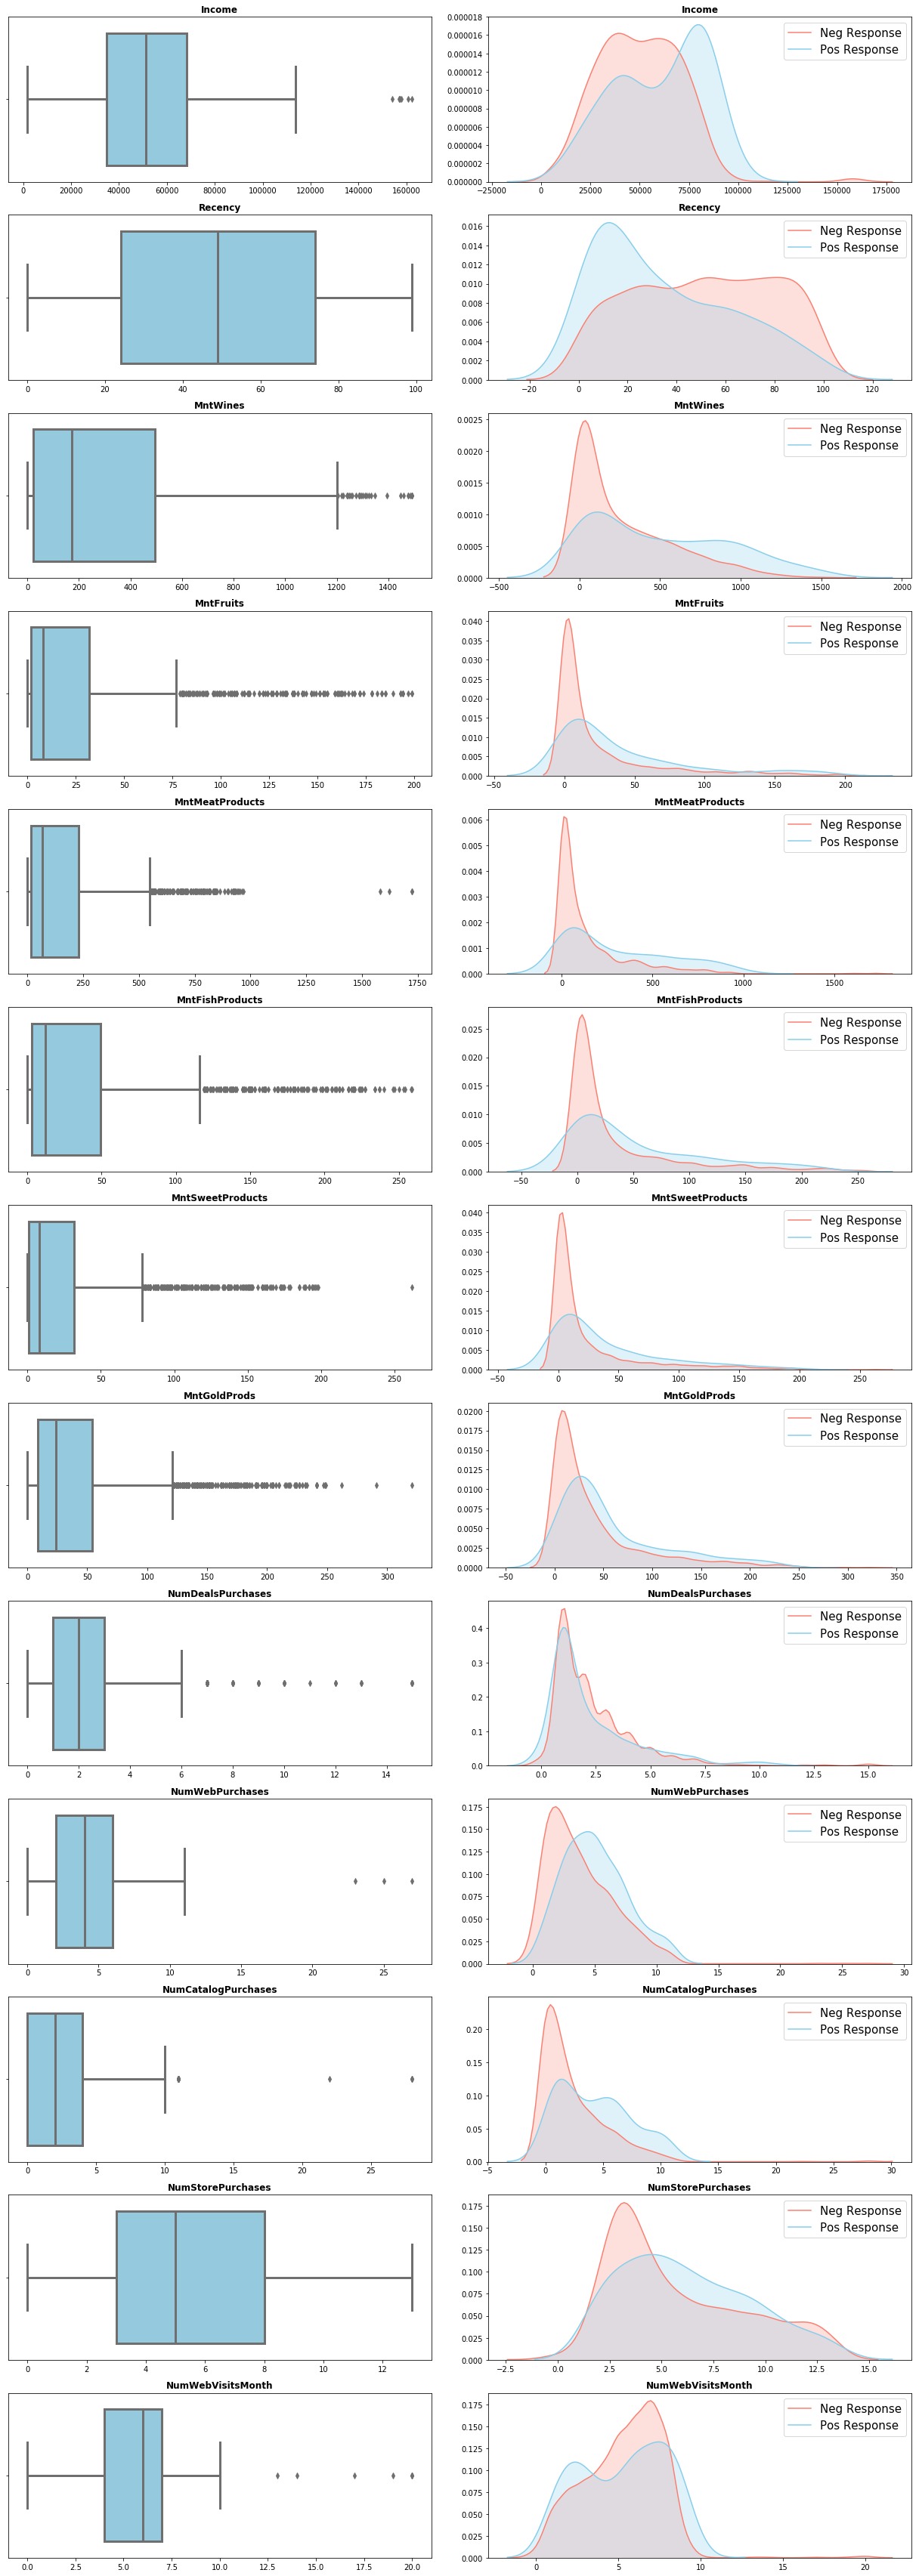

In [14]:
fig = plt.figure(figsize=(17, 80))
i = 1
for col in distribution_cols:
    ax = fig.add_subplot(df_numeric.shape[1], 2, i)
    #violin = sns.violinplot(x=col, data = df, palette="muted", inner = 'box',linewidth=3)
    box = sns.boxplot(x=col,data=df, linewidth=3, color="skyblue")
    #box = ax.boxplot(df[col], flierprops=dict(markerfacecolor='r', marker='s'), vert=False, patch_artist=True)
    ax.set_title(col, fontweight = 'bold')
    ax.set_xlabel(None)
    ax = fig.add_subplot(df_numeric.shape[1], 2, i+1)
    p1 = sns.kdeplot(df.loc[df.Response==0,col], shade=True, color="salmon", label='Neg Response')
    p1 = sns.kdeplot(df.loc[df.Response==1,col], shade=True, color="skyblue", label='Pos Response')
    ax.set_title(col, fontweight = 'bold')
    ax.legend(fontsize=15)
    i+=2
    
plt.tight_layout()
plt.savefig('outliers')
plt.show

### IQR and STD

In [8]:
def filter_by_std(series_, n_stdev=3.0, return_thresholds=False):
    mean_, stdev_ = series_.mean(), series_.std()
    cutoff = stdev_ * n_stdev
    lower_bound, upper_bound = mean_ - cutoff, mean_ + cutoff
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]
    
def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    
    cutoff = iqr*k
    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]
    
def plot_filter_by_stdev(df, feature, n_stdev=3.0, color="red"):
    lower_bound, upper_bound = filter_by_std(df[feature], n_stdev=n_stdev, return_thresholds=True)
    if df[feature].min()<=0:
        plt.axvspan(min(df[feature][df[feature] <lower_bound], default=df[feature].min()), lower_bound, alpha=0.2, color=color)
    plt.axvspan(upper_bound, max(df[feature][df[feature] > upper_bound], default=df[feature].max()), alpha=0.2, color=color)
    plt.title("Outliers in {} by {} standard deviations:\n".format(feature, n_stdev))
    
def plot_filter_by_iqr(df, feature, k=1.5, color="red"):
    lower_bound, upper_bound = filter_by_iqr(df[feature], k=k, return_thresholds=True)
    if df[feature].min()<=0:
        plt.axvspan(min(df[feature][df[feature] <lower_bound], default=df[feature].min()), lower_bound, alpha=0.2, color=color)
    plt.axvspan(upper_bound, max(df[feature][df[feature] > upper_bound], default=df[feature].max()), alpha=0.2, color=color)
    plt.title("Outliers in {} by {} k in IQR:\n".format(feature, k))

In [9]:
# Don't Apply to binary variables 

non_binary = [x for x in df_numeric.columns.values if not x.startswith("Acc") and not x.startswith('Compl')]
print(non_binary)

['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']


### comparing outliers method

In [10]:
outliers_dict=dict()
def add_outliers_method(method, idx_to_remove, outliers_dict):
    
    outliers_dict[method]= idx_to_remove 
    return(outliers_dict)

In [11]:
#for feature in df_numeric.columns:     
idx_to_remove_std = []
idx_to_remove_iqr = []
for feature in non_binary:
    id_std = df_numeric[feature][filter_by_std(df_numeric[feature], 3)].index.tolist()
    id_iqr = df_numeric[feature][filter_by_iqr(df_numeric[feature], 1.7)].index.tolist()
    idx_to_remove_std.append(id_std)
    idx_to_remove_iqr.append(id_iqr)
    cross_outliers = list(set(id_std).intersection(id_iqr))
    idx_to_remove = set(cross_outliers)
    print(feature,'Number of outliers:\t{}'.format(len(cross_outliers))) 
    print(feature,'Percentage of dataset:\t{0:.0%}'.format(len(cross_outliers)/len(df_numeric))) 
    print('----------------------------------') 

   
# Flaten lists
idx_to_remove_std = [item for sublist in idx_to_remove_std for item in sublist]
idx_to_remove_iqr = [item for sublist in idx_to_remove_iqr for item in sublist]
# cross_outliers
cross_outliers = list(set(idx_to_remove_std).intersection(idx_to_remove_iqr))
# keep unique
idx_to_remove = set(cross_outliers)
#print('Outlier ID: {}'.format(cross_outliers)) 
print('----------------------------------') 
print('Number of outliers:\t{}'.format(len(cross_outliers))) 
print('Percentage of dataset:\t{0:.0%}'.format(len(cross_outliers)/len(df_numeric))) 
print('----------------------------------') 

outliers_dict=add_outliers_method('3std_17iqr', cross_outliers, outliers_dict)

Year_Birth Number of outliers:	2
Year_Birth Percentage of dataset:	0%
----------------------------------
Income Number of outliers:	7
Income Percentage of dataset:	0%
----------------------------------
Kidhome Number of outliers:	0
Kidhome Percentage of dataset:	0%
----------------------------------
Teenhome Number of outliers:	0
Teenhome Percentage of dataset:	0%
----------------------------------
Recency Number of outliers:	0
Recency Percentage of dataset:	0%
----------------------------------
MntWines Number of outliers:	15
MntWines Percentage of dataset:	1%
----------------------------------
MntFruits Number of outliers:	52
MntFruits Percentage of dataset:	3%
----------------------------------
MntMeatProducts Number of outliers:	23
MntMeatProducts Percentage of dataset:	1%
----------------------------------
MntFishProducts Number of outliers:	47
MntFishProducts Percentage of dataset:	3%
----------------------------------
MntSweetProducts Number of outliers:	49
MntSweetProducts Perc

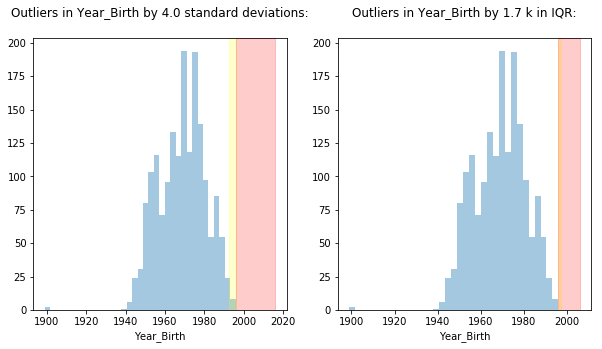

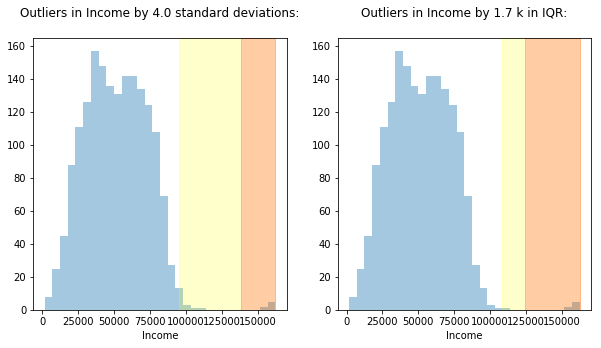

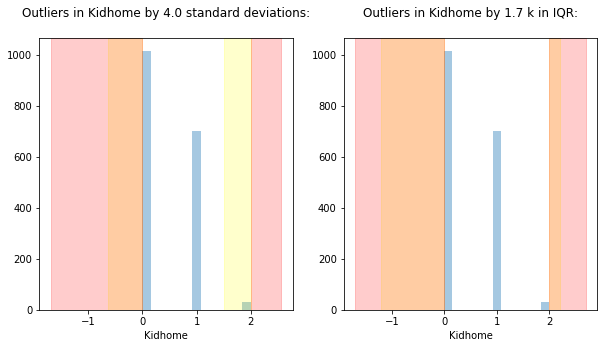

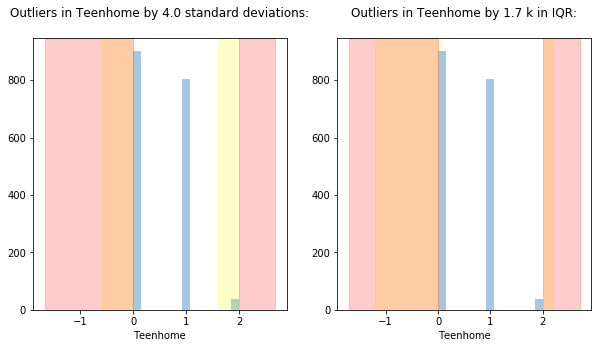

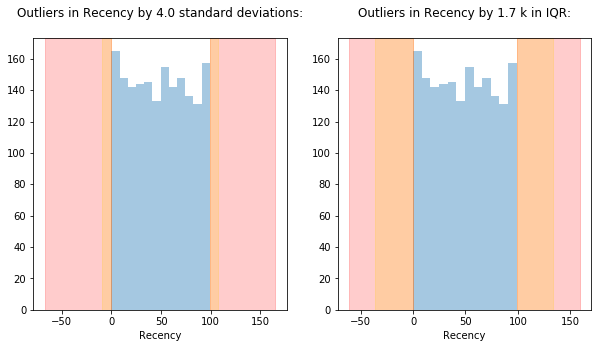

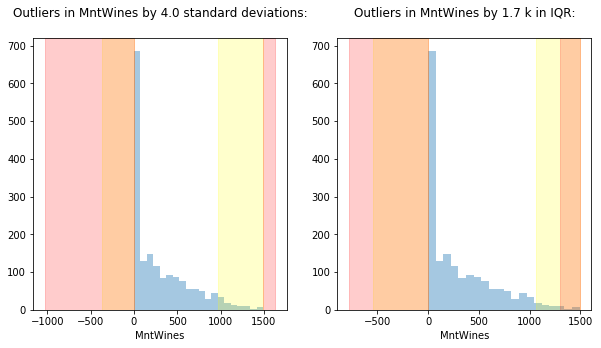

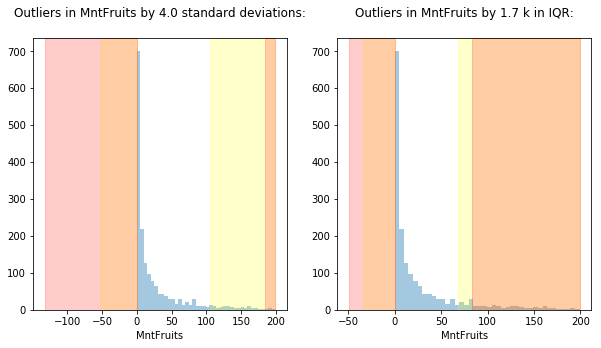

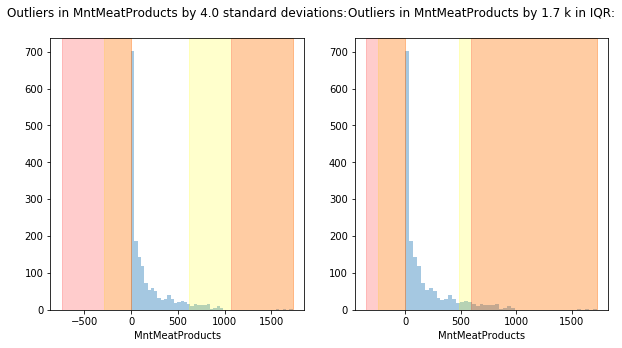

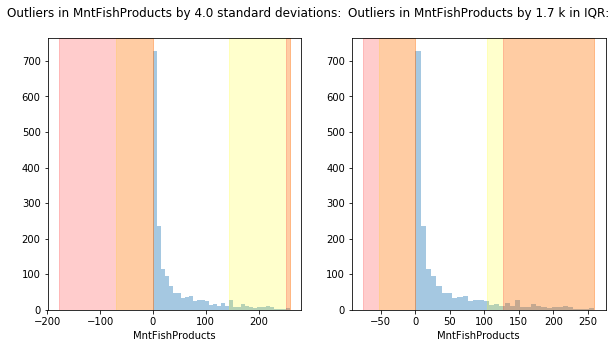

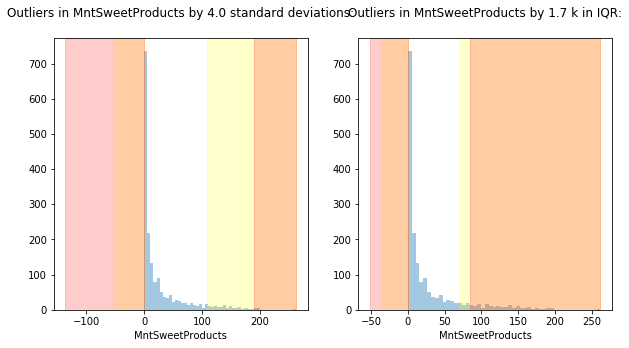

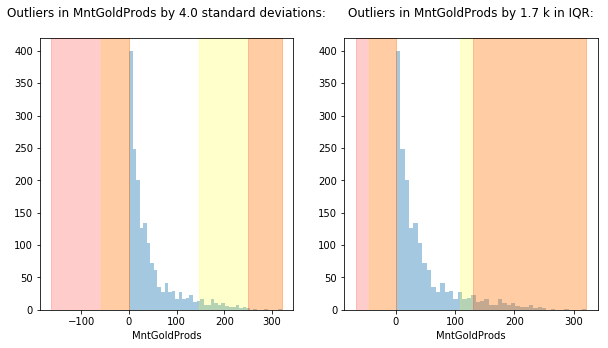

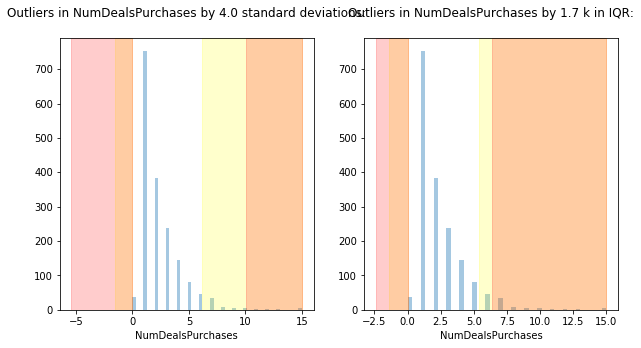

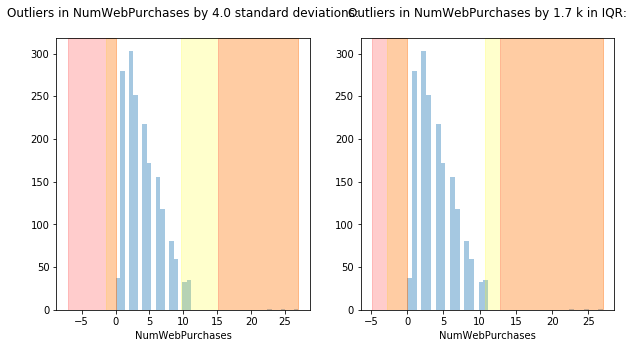

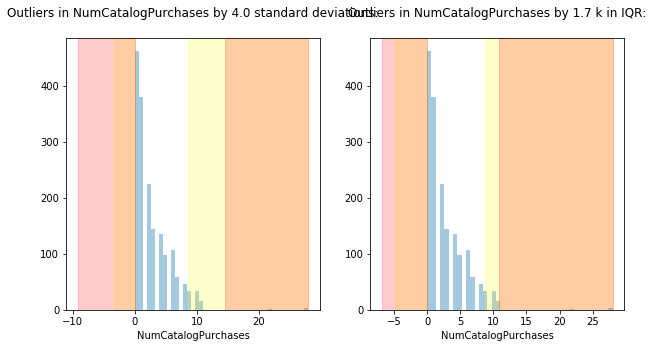

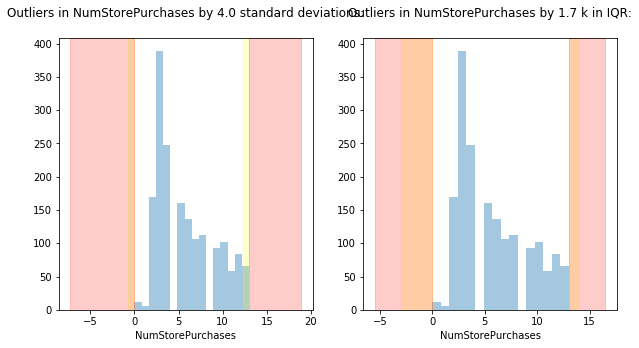

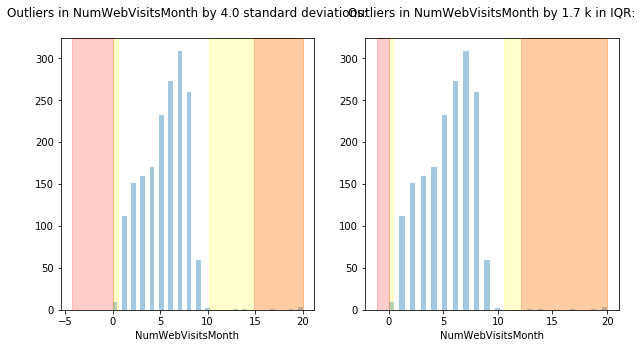

In [12]:
for feature in non_binary:    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    sns.distplot(df_numeric[feature], kde=False)
    plot_filter_by_stdev(df_numeric, feature, n_stdev=2.0, color='yellow')
    plot_filter_by_stdev(df_numeric, feature, n_stdev=4.0, color='red')
    plt.subplot(122)
    sns.distplot(df_numeric[feature], kde=False)
    plot_filter_by_iqr(df_numeric, feature, k=1.2, color='yellow')
    plot_filter_by_iqr(df_numeric, feature, k=1.7, color='red')

In [13]:
# DBSCAN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_var = scaler.fit_transform(df_numeric[non_binary])
scaled_df = pd.DataFrame(scaled_var, columns = non_binary)
scaled_df.head(5)


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,0.752577,0.278172,0.5,0.5,0.060606,0.045546,0.000000,0.009275,0.000000,0.000000,0.024922,0.200000,0.074074,0.000000,0.307692,0.35
1,0.536082,0.431806,0.0,0.5,0.616162,0.356999,0.050251,0.125797,0.764479,0.664122,0.607477,0.133333,0.259259,0.214286,1.000000,0.20
2,0.876289,0.213971,0.5,0.0,0.686869,0.094441,0.040201,0.074783,0.011583,0.041985,0.146417,0.200000,0.259259,0.035714,0.307692,0.45
3,0.680412,0.446937,0.0,0.5,0.929293,0.543202,0.381910,0.248116,0.382239,0.522901,0.333333,0.200000,0.370370,0.142857,0.692308,0.35
4,0.793814,0.221981,0.5,0.0,0.474747,0.012056,0.000000,0.005217,0.000000,0.003817,0.034268,0.066667,0.037037,0.000000,0.230769,0.30


In [14]:

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 2,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(scaled_df)
cluster = pd.concat([scaled_df,pd.Series(clusters)],axis = 1)
idx_dbscan = cluster.loc[cluster[0] == -1].index.tolist()

outliers_dict=add_outliers_method('dbscan', idx_dbscan, outliers_dict)

In [15]:
'''
# cross_outliers
cross_outliers_ = list(set(idx_to_remove).intersection(idx_dbscan))
# keep unique
idx_to_remove_ = set(cross_outliers)
#print('Outlier ID: {}'.format(cross_outliers)) 
print('----------------------------------') 
print('Number of outliers:\t{}'.format(len(cross_outliers_))) 
print('Percentage of dataset:\t{0:.0%}'.format(len(cross_outliers_)/len(df_numeric))) 
print('----------------------------------') 
'''

"\n# cross_outliers\ncross_outliers_ = list(set(idx_to_remove).intersection(idx_dbscan))\n# keep unique\nidx_to_remove_ = set(cross_outliers)\n#print('Outlier ID: {}'.format(cross_outliers)) \nprint('----------------------------------') \nprint('Number of outliers:\t{}'.format(len(cross_outliers_))) \nprint('Percentage of dataset:\t{0:.0%}'.format(len(cross_outliers_)/len(df_numeric))) \nprint('----------------------------------') \n"

## SKLEARN OUTLIER DETECTION
Winsorizing (resolver)


In [16]:
x = df_numeric[non_binary]
x.head(1)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
ID,,,,,,,,,,,,,,,,
67,1972,46423,1,1,6,68,0,16,0,0,8,3,2,0,4,7


In [17]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

# training the model
clf = IsolationForest(max_samples=500, random_state=0)
clf.fit(x)

# predictions
predictions = clf.predict(x)


In [18]:
x['isolation_forest']=predictions.tolist()
idx_isolation=x.loc[x['isolation_forest'] == -1].index.tolist()
x.drop(columns=['isolation_forest'])

outliers_dict=add_outliers_method('isolation_forest',idx_isolation, outliers_dict)


In [19]:
from collections import Counter

print(Counter(predictions).keys())
print(Counter(predictions).values())


dict_keys([1, -1])
dict_values([1571, 175])


In [20]:

from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors

In [21]:

clf = LocalOutlierFactor(novelty = True)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit(x)
#n_errors = (y_pred != ground_truth).sum()
#X_scores = clf.negative_outlier_factor_


In [22]:

# predictions
predictions = clf.predict(x)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
x['lof']=predictions.tolist()
idx_isolation=x.loc[x['lof'] == -1].index.tolist()
x.drop(columns=['lof'])
outliers_dict=add_outliers_method('lof',idx_isolation, outliers_dict)


In [24]:
from collections import Counter


print(Counter(predictions).keys())
print(Counter(predictions).values())


dict_keys([1, -1])
dict_values([1602, 144])


### mahalanobis

In [25]:
from scipy.spatial.distance import mahalanobis
import scipy as sp
x = df_numeric[non_binary]
#x = scaled_df.copy()

inv_cov = x.cov().values
inv_cov = sp.linalg.inv(inv_cov)
mean = x.mean().values

def mahalanobis_dis(X,meanCol,IC):
    md = pd.DataFrame(columns=['mahalanobis'], index=X.index)
    for i in X.index.values:
        md['mahalanobis'][i]=mahalanobis(X.loc[i,],meanCol,IC)
    return(md)

In [26]:
mahal_dis=mahalanobis_dis(x, mean, inv_cov)

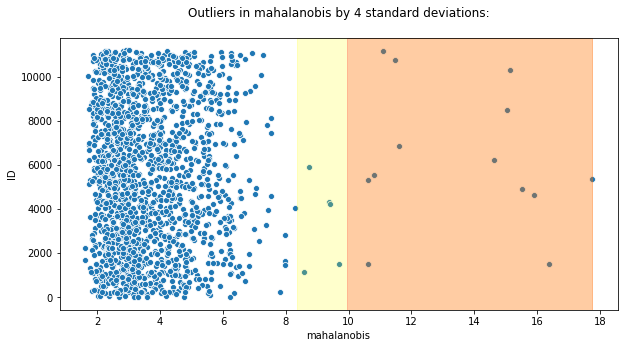

In [27]:
#PLOT distances
n_dev=4

plt.figure(figsize=(10,5))
sns.scatterplot(mahal_dis['mahalanobis'], mahal_dis.index)
plot_filter_by_stdev(mahal_dis, 'mahalanobis', n_stdev=n_dev-1, color='yellow') #normalize
plot_filter_by_stdev(mahal_dis, 'mahalanobis', n_stdev=n_dev, color='red') #delete
plt.show()

In [28]:
#dealing with outliers

m_std=mahal_dis[mahal_dis.columns[0]].std()
m_mean=mahal_dis[mahal_dis.columns[0]].mean()

n_dev=4
outliers=mahal_dis[mahal_dis[mahal_dis.columns[0]]>=(m_mean+(m_std*n_dev))]

idx_mahalanobis4=outliers.index
print('mahalanobis','Number of outliers:\t{} with {} std'.format(len(outliers), n_dev)) 
print('mahalanobis','Percentage of dataset:\t{0:.2%}'.format(len(outliers)/len(mahal_dis))) 
print('----------------------------------') 

outliers_dict=add_outliers_method('mahalanobis_4',idx_mahalanobis4, outliers_dict)

mahalanobis Number of outliers:	13 with 4 std
mahalanobis Percentage of dataset:	0.74%
----------------------------------


In [29]:
n_dev=3
outliers=mahal_dis[mahal_dis[mahal_dis.columns[0]]>=(m_mean+(m_std*n_dev))]

idx_mahalanobis3=outliers.index
print('mahalanobis','Number of outliers:\t{} with {} std'.format(len(outliers), n_dev)) 
print('mahalanobis','Percentage of dataset:\t{0:.2%}'.format(len(outliers)/len(mahal_dis))) 
print('----------------------------------') 

outliers_dict=add_outliers_method('mahalanobis_3',idx_mahalanobis3, outliers_dict)

mahalanobis Number of outliers:	18 with 3 std
mahalanobis Percentage of dataset:	1.03%
----------------------------------


In [30]:
n_dev=4
dec='del'
dec_1=''

out=mahal_dis[mahal_dis['mahalanobis']>=(m_mean+(m_std*(n_dev-1)))]
inliers=mahal_dis[mahal_dis['mahalanobis']<(m_mean+(m_std*(n_dev-1)))]

max_dist = max(inliers.mahalanobis)
ind=inliers[inliers['mahalanobis'] == max_dist].index[0]

for_delete=[]

for i in out.index:
    if out.mahalanobis[i]>=m_mean+(m_std*(n_dev)):
        if dec=='del':
            for_delete.append(i)
        else:
            ind=find_nearest(i,out.mahalanobis[i], inliers)
            df.loc[i]=df.loc[ind]
    else:
        if dec_1=='del':
            for_delete.append(i)
        else:
            df.loc[i]=df.loc[ind]

df_after_mahal=df[~df.index.isin(for_delete)]            

In [31]:
print(df_after_mahal.shape, df.shape)

(1733, 26) (1746, 26)


In [32]:
#print('Deleted Observations: {0:.2%}'.format(1-df_after_mahal.shape[0]/x_train.shape[0]))

In [33]:
### checking unispatial outliers after removing multidimensional space outliers

# Don't Apply to binary variables 

#non_binary = [x for x in df_numeric.columns.values if not x.startswith("Acc") and not x.startswith('Compl')]
#print(non_binary)

#exploring number of outliers
out=df_after_mahal[non_binary]
m=out.mean()
s=out.std()
out.shape

(1733, 16)

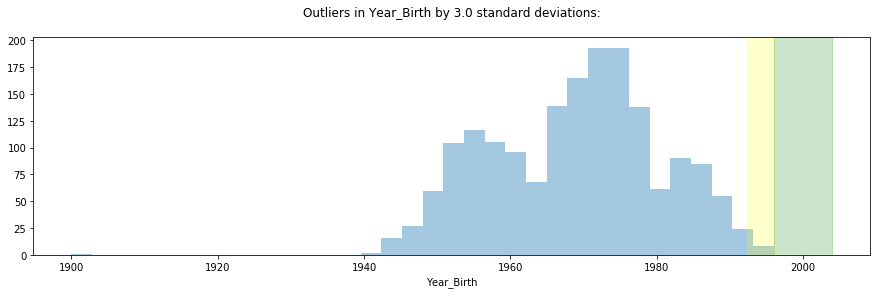

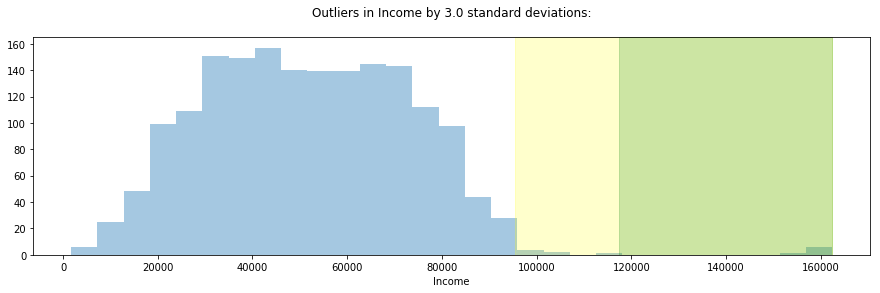

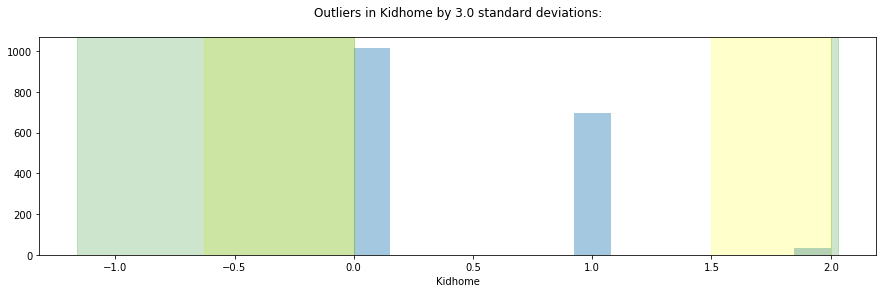

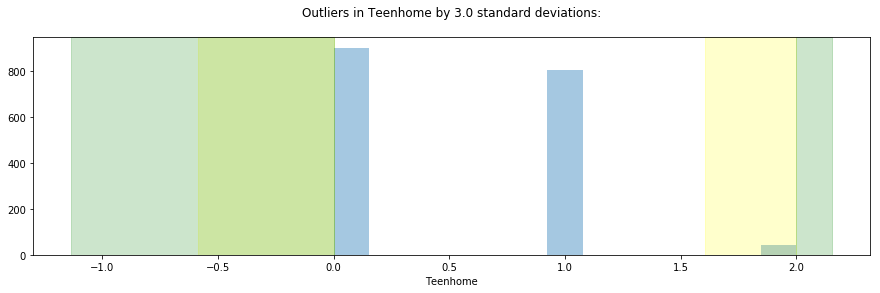

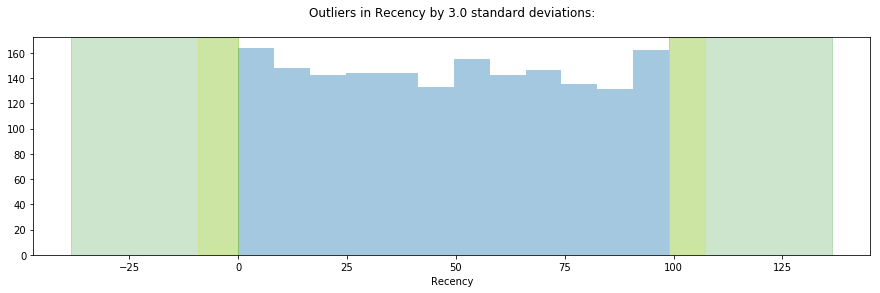

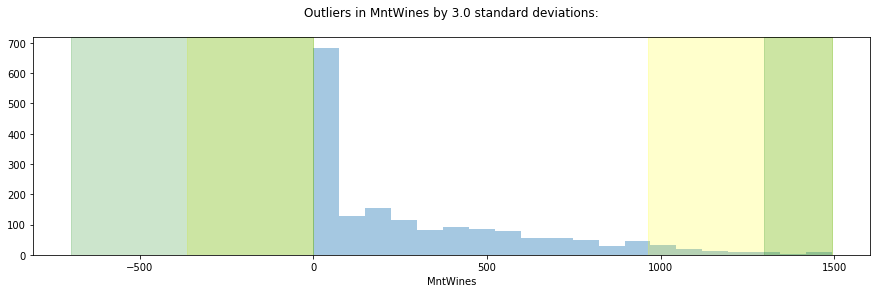

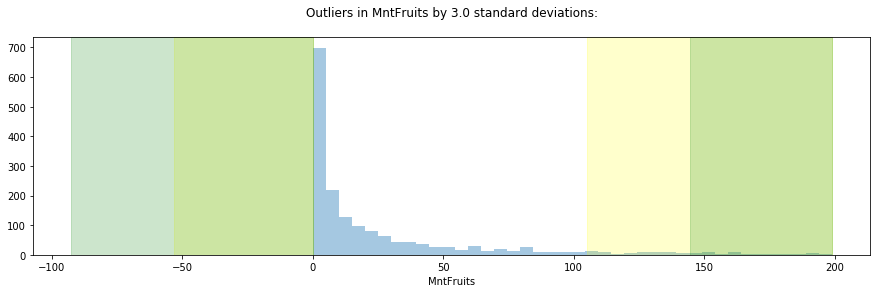

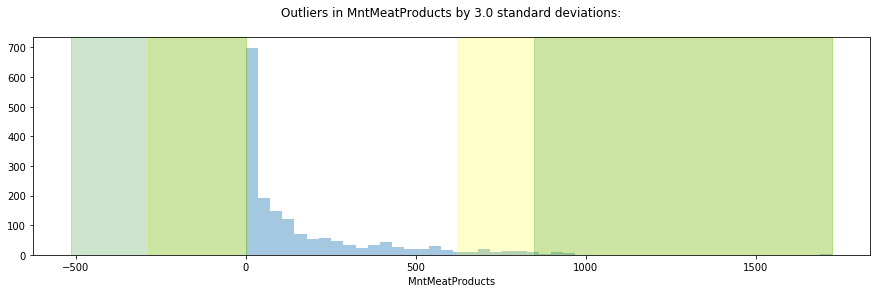

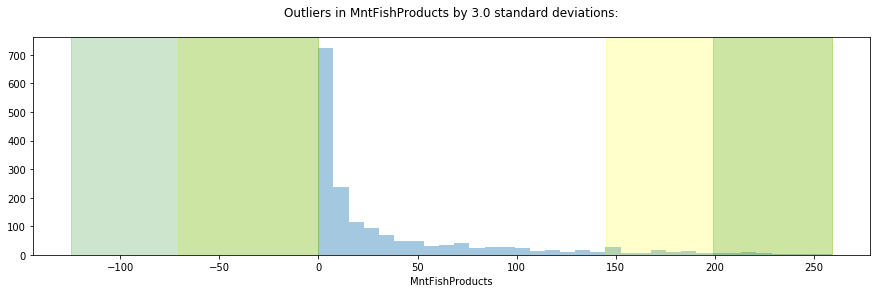

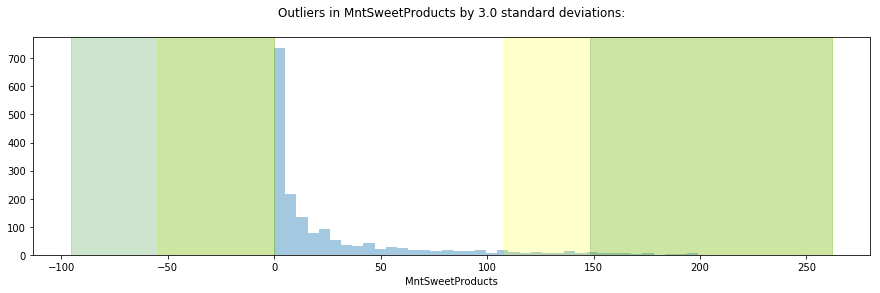

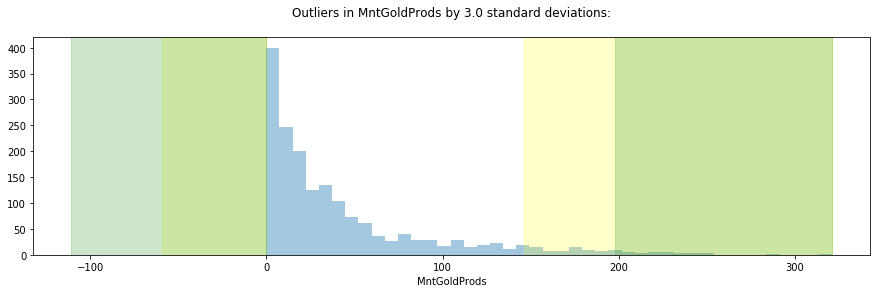

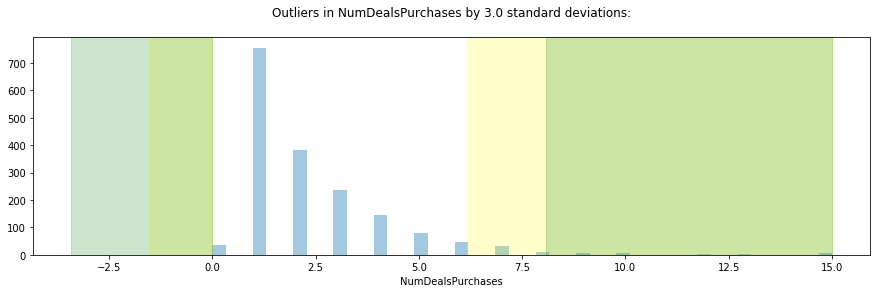

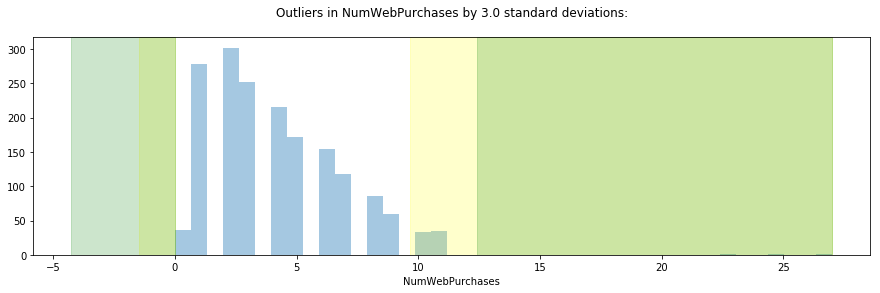

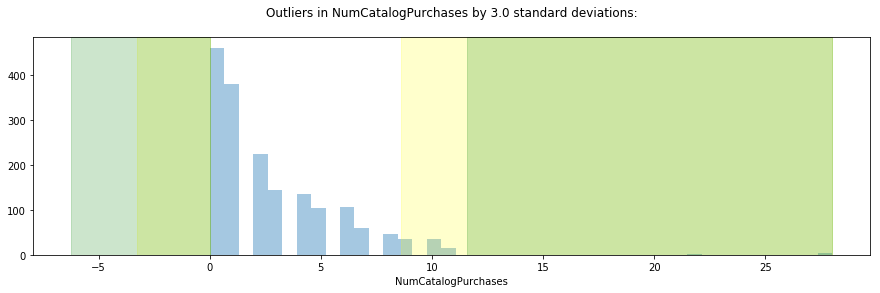

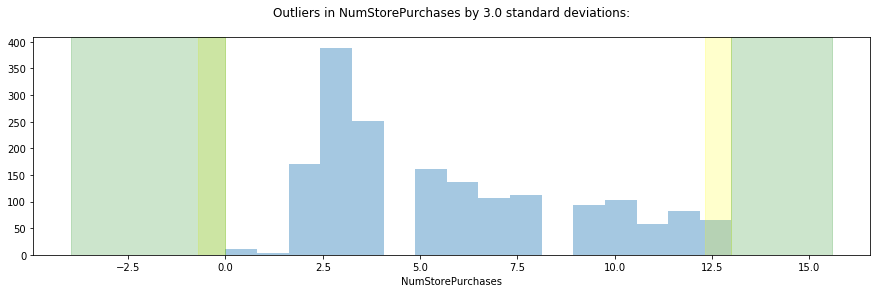

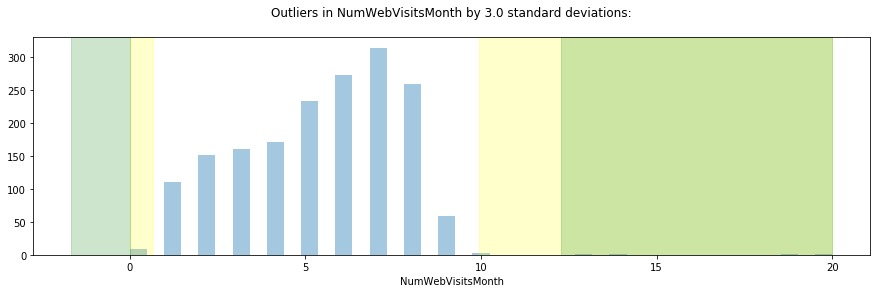

In [34]:
for feature in non_binary:    
    plt.figure(figsize=(15,4))
    sns.distplot(df[feature], kde=False)
    plot_filter_by_stdev(df, feature, n_stdev=2.0, color='yellow')
    plot_filter_by_stdev(df, feature, n_stdev=3.0, color='green')


In [35]:
counter=0
mais=0
menos=0
n_std=4

idx_mahalanobis4 = list(idx_mahalanobis4)
#to check number of outliers per feature
for col in out.columns:
    
    mais=0
    menos=0
    for i in out.index:
        if df_after_mahal[col][i]>=m[col]+(s[col]*n_std):
            counter+=1
            mais+=1
            idx_mahalanobis4.append(i)
            
        elif df_after_mahal[col][i]<=m[col]-(s[col]*n_std):
            counter+=1
            menos+=1
            idx_mahalanobis4.append(i)
            #df.drop(axis=0, index=[i], inplace=True)
    print(col,'total:', counter, 'right ', mais, 'left ', menos)
    
outliers_dict=add_outliers_method('mahal_uni4', idx_mahalanobis4, outliers_dict)

Year_Birth total: 1 right  0 left  1
Income total: 1 right  0 left  0
Kidhome total: 1 right  0 left  0
Teenhome total: 1 right  0 left  0
Recency total: 1 right  0 left  0
MntWines total: 1 right  0 left  0
MntFruits total: 12 right  11 left  0
MntMeatProducts total: 12 right  0 left  0
MntFishProducts total: 15 right  3 left  0
MntSweetProducts total: 26 right  11 left  0
MntGoldProds total: 29 right  3 left  0
NumDealsPurchases total: 41 right  12 left  0
NumWebPurchases total: 41 right  0 left  0
NumCatalogPurchases total: 41 right  0 left  0
NumStorePurchases total: 41 right  0 left  0
NumWebVisitsMonth total: 41 right  0 left  0


In [36]:
#max value without n_std
def valid_values(col, n_std):
    
        m = col.mean()
        s= col.std()
        valid=col[col<m+(s*n_std)]
        valid=valid[valid>m-(s*n_std)]
    

        return(valid.min(), valid.max())



#to change oultiers by max or min value admisseble
for col in out.columns:
    
    bottom, top = valid_values(df_after_mahal[col], n_std)

    for i in df_after_mahal.index.values:
        
        if df_after_mahal[col][i]>=m[col]+(s[col]*n_std):
         
            df_after_mahal[col][i]=top
            
        elif df_after_mahal[col][i]<=m[col]-(s[col]*n_std):
            df_after_mahal[col][i]=bottom

## compare models with different outliers methods

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, recall_score, average_precision_score

In [38]:
n_splits = 5
outliers_df=pd.DataFrame(index=range(len(outliers_dict.keys())*n_splits), columns=(['method','recall', 'accuracy', 'precision', 'f1']))
CV = KFold(n_splits=n_splits, random_state=seed)

In [39]:
n_splits = 10
scoring =['recall', 'accuracy', 'precision', 'f1']
entries = []

scaler = MinMaxScaler()
l=pd.DataFrame()

for score in scoring:
   
    entries = []
    for key in outliers_dict.keys():

        y_train = df['Response'].loc[set(df.index)-set(outliers_dict[key])]
        x = df.loc[set(df.index)-set(outliers_dict[key])].select_dtypes(include=['number']).drop(columns=['Response'])

        x_train = scaler.fit_transform(x)
        accuracies = cross_val_score(LogisticRegression(n_jobs=-1), x_train, y_train, scoring=score, cv=CV)

        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((key, fold_idx, accuracy))
        
    outliers_df = pd.DataFrame(entries, columns=['method', 'fold_idx', score])
    l[score] = outliers_df.groupby('method')[score].agg('mean')
#l.append(cv_df.groupby('model_name')[score].agg('mean'))
   

In [40]:
l.sort_values(by=['f1', 'recall'], ascending=False)

,recall,accuracy,precision,f1
method,,,,
mahalanobis_4,0.363787,0.888055,0.756229,0.490480
mahalanobis_3,0.366343,0.889461,0.743908,0.489563
mahal_uni4,0.363533,0.888880,0.747445,0.487802
dbscan,0.355371,0.884017,0.712129,0.472843
isolation_forest,0.336427,0.897517,0.774820,0.462530
3std_17iqr,0.305082,0.897910,0.757804,0.430748
lof,0.281110,0.888879,0.718861,0.403502


### method for outliers --> MAHALANOBIS 4STD

In [41]:
df = df.loc[~df.index.isin(outliers_dict['mahalanobis_4'])]
df.shape

(1733, 26)

In [42]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
67,1972,Master,Single,46423,1,1,2013-09-18,6,68,0,...,0,4,7,0,0,0,0,0,0,0
3828,1951,Graduation,Married,71107,0,1,2013-02-17,61,533,10,...,6,13,4,0,0,0,0,0,0,0
3409,1984,Graduation,Single,36108,1,0,2013-10-15,68,141,8,...,1,4,9,1,0,0,0,0,0,0
9451,1965,Graduation,Married,73538,0,1,2012-11-25,92,811,76,...,4,9,7,0,0,0,0,0,0,0
6211,1976,PhD,Together,37395,1,0,2014-05-02,47,18,0,...,0,3,6,0,0,0,0,0,0,0


# 2. Missing Values

## 2.1 Dealing with missing

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from tqdm import tqdm

In [44]:
def clean_missings_test(df_test, df_train):
    # Sample that we are going to imputate
    #impute_metrics = {key: [] for key in df_no_miss.columns}
    
    df_no_miss = df_train.select_dtypes(include=["number"]).drop(columns = 'Response').copy()
    
    scaler = MinMaxScaler()

    models = [ExtraTreesRegressor(random_state=seed),
              BayesianRidge(),
              DecisionTreeRegressor(random_state=seed),
              KNeighborsRegressor()]
    models_names = [model.__class__.__name__ for model in models]
    mod_dict = dict(zip(models_names,models))
    
    df_test_no_miss = df_test.copy()
    
    # cols that have missing
    null_col_test = df_test_no_miss.columns[df_test.isna().any()].tolist()
    
    for col in tqdm(null_col_test):        
        
        # slice with nulls
        test_null = df_test_no_miss.loc[df_test_no_miss[col].isnull()].drop(columns = [col,'Response']).select_dtypes(include=["number"])

        best_error = np.inf
        best_metric = None
        best_model_name = None

        x_ = df_no_miss.drop(columns=[col])
        y_ = df_no_miss[col]
        x_ = scaler.fit_transform(x_)

        x_t_ = scaler.transform(test_null)

        for mod_name, model in mod_dict.items():

            model.fit(x_, y_)  
            sqr_err = model_selection.cross_val_score(model, x_, y_, scoring='neg_mean_squared_error', cv = 5)

            if sqr_err.mean() < best_error:
                best_metric = model
                best_model_name = mod_name
                best_error = sqr_err.mean()
        
        print(col,'\tBest metric:',best_model_name)
        prediction = best_metric.predict(x_t_)         
        #impute_metrics[col] = best_metric
        df_test_no_miss.loc[df_test_no_miss[col].isnull(), col] = prediction
        #print(prediction)
        
        return df_test_no_miss
    

In [45]:
df_test = clean_missings_test(df_test, df)

  0%|          | 0/1 [00:00<?, ?it/s]

Income 	Best metric: DecisionTreeRegressor


# 3. New Variables

* Age
* Days_as_cust: # of days as customer
* Mnt_tot: Sum of all purchases mnt
* Frq: # of times the client made a purchase
* Childnum: total # of children (kids+teens)
* RatioMntFrq: Monetary over # of purchases
* RatioMntIncome: Monetary over income
* AcceptedTot: Total # of accepted campaigns
* RatioDealFrq: Ratio of purchases with discount
* RatioWebPurchWebVisit: # of purchases over visits
* Each expense in percentage
* Ratio channel of purchase

#### Age

In [46]:
most_recent_obs = df['Dt_Customer'].max()
most_recent_obs

# test

df_test['Age'] = most_recent_obs.year - df_test.Year_Birth

In [47]:
df['Age'] = most_recent_obs.year - df.Year_Birth

In [48]:
df[["Year_Birth","Age"]].head(1)

,Year_Birth,Age
ID,,
67,1972,42


In [49]:
# remove Year_Birth
#df.drop(columns = ['Year_Birth'], inplace=True)

#### Days_as_cust

In [50]:
# Days
df['Days_as_cust'] = most_recent_obs - df.Dt_Customer
df['Days_as_cust'] = df['Days_as_cust'].dt.days

# test
df_test['Days_as_cust'] = most_recent_obs - df_test.Dt_Customer
df_test['Days_as_cust'] = df_test['Days_as_cust'].dt.days

In [51]:
df[["Dt_Customer","Days_as_cust"]].head(1)

,Dt_Customer,Days_as_cust
ID,,
67,2013-09-18,284


#### Mnt_tot

In [52]:
mnt_features = [x for x in df.columns.values if x.startswith("Mnt")]

In [53]:
df['Mnt_tot'] = np.sum(df[mnt_features], axis=1)

# test
df_test['Mnt_tot'] = np.sum(df_test[mnt_features], axis=1)

In [54]:
pd.concat([df[mnt_features],df["Mnt_tot"]], axis=1).head(1)

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Mnt_tot
ID,,,,,,,
67,68,0,16,0,0,8,92


#### Frq

In [55]:
df['Frq'] = np.sum(df[["NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]], axis=1)

# test
df_test['Frq'] = np.sum(df_test[["NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]], axis=1)

In [56]:
df[["NumWebPurchases","NumCatalogPurchases","NumStorePurchases","Frq"]].head(1)

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Frq
ID,,,,
67,2,0,4,6


#### Childnum

In [57]:
df['Childnum'] = np.sum(df[["Kidhome","Teenhome"]], axis=1)

# test
df_test['Childnum'] = np.sum(df_test[["Kidhome","Teenhome"]], axis=1)

In [58]:
df[["Kidhome","Teenhome","Childnum"]].head(2)

,Kidhome,Teenhome,Childnum
ID,,,
67,1,1,2
3828,0,1,1


#### R_MntFrq

In [59]:
df['R_MntFrq'] = np.divide(df['Mnt_tot'],df['Frq'])

# test
df_test['R_MntFrq'] = np.divide(df_test['Mnt_tot'],df_test['Frq'])

In [60]:
df[["Mnt_tot","Frq","R_MntFrq"]].head(1)

,Mnt_tot,Frq,R_MntFrq
ID,,,
67,92,6,15.333333


#### RatioMntIncome

In [61]:
df['R_MntIncome'] = np.divide(df['Mnt_tot'],df['Income'])

# test
df_test['R_MntIncome'] = np.divide(df_test['Mnt_tot'],df_test['Income'])

In [62]:
df[["Mnt_tot","Income","R_MntIncome"]].head(1)

,Mnt_tot,Income,R_MntIncome
ID,,,
67,92,46423,0.001982


#### AcceptedTot

In [63]:
Accept_cat = [x for x in df.columns.values if x.startswith("AcceptedCmp")]

In [64]:
df['AcceptedTot'] = np.sum(df[Accept_cat], axis=1)

# test
df_test['AcceptedTot'] = np.sum(df_test[Accept_cat], axis=1)


In [65]:
pd.concat([df[Accept_cat],df["AcceptedTot"]], axis=1).loc[pd.concat([df[Accept_cat],df["AcceptedTot"]], axis=1).AcceptedTot ==3].head(1)

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,AcceptedTot
ID,,,,,,
7832,1,0,1,1,0,3


#### RatioDealFrq

In [66]:
df['R_DealFrq'] = np.divide(df['NumDealsPurchases'],df['Frq'])

# test
df_test['R_DealFrq'] = np.divide(df_test['NumDealsPurchases'],df_test['Frq'])


In [67]:
df[["NumDealsPurchases","Frq","R_DealFrq"]].head(1)

,NumDealsPurchases,Frq,R_DealFrq
ID,,,
67,3,6,0.5


#### RatioWebPurchWebVisit !!!!! Visitas sao so no ultimo mês

In [68]:
#df['R_WebPurchWebVisit'] = np.divide(df['NumWebPurchases'],df['NumWebVisitsMonth'])

In [69]:
#df[["NumWebPurchases","NumWebVisitsMonth","R_WebPurchWebVisit"]].head(2)

#### Ratio Mnts specific vs Mnt_tot

In [70]:
for feat in mnt_features:
    df['R_'+ feat] = df[feat]/df["Mnt_tot"]
    # test
    df_test['R_'+ feat] = df_test[feat]/df_test["Mnt_tot"]

In [71]:
# ex
df[["MntWines", "Mnt_tot", "R_MntWines"]].head(1)

,MntWines,Mnt_tot,R_MntWines
ID,,,
67,68,92,0.73913


### RFM Score

In [72]:
# 1) bin Rcn, Frq and Mnt
feature_list, n_bins = ["Recency", "Frq", "Mnt_tot"], 5
rfm_feature_dict = {}
for feature in feature_list:
    bindisc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile")
    feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
    feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
    feature_bin += 1
    
    if feature == "Rcn":
        feature_bin = feature_bin.sub(5).abs() + 1
    rfm_feature_dict[feature+"_bin"] = feature_bin.astype(int).astype(str)

rfm_feature_dict.keys()

dict_keys(['Recency_bin', 'Frq_bin', 'Mnt_tot_bin'])

In [73]:
df["RFM"] = (rfm_feature_dict['Recency_bin'] + rfm_feature_dict['Frq_bin'] + rfm_feature_dict['Mnt_tot_bin']).astype(int)
df.head(1)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,R_MntIncome,AcceptedTot,R_DealFrq,R_MntWines,R_MntFruits,R_MntMeatProducts,R_MntFishProducts,R_MntSweetProducts,R_MntGoldProds,RFM
ID,,,,,,,,,,,,,,,,,,,,,
67,1972,Master,Single,46423,1,1,2013-09-18,6,68,0,...,0.001982,0,0.5,0.73913,0.0,0.173913,0.0,0.0,0.086957,122


In [74]:
# test

feature_list, n_bins = ["Recency", "Frq", "Mnt_tot"], 5
rfm_feature_dict = {}
for feature in feature_list:
    bindisc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile")
    feature_bin = bindisc.fit_transform(df_test[feature].values[:, np.newaxis])
    feature_bin = pd.Series(feature_bin[:, 0], index=df_test.index)
    feature_bin += 1
    
    if feature == "Rcn":
        feature_bin = feature_bin.sub(5).abs() + 1
    rfm_feature_dict[feature+"_bin"] = feature_bin.astype(int).astype(str)

rfm_feature_dict.keys()
df_test["RFM"] = (rfm_feature_dict['Recency_bin'] + rfm_feature_dict['Frq_bin'] + rfm_feature_dict['Mnt_tot_bin']).astype(int)


### Channel Ratios

In [75]:
channels = ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']

for channel in channels:
    df['R_'+channel] = df[channel]/df['Frq']
    # test
    df_test['R_'+channel] = df_test[channel]/df_test['Frq']

In [76]:
df[['NumWebPurchases','Frq','R_NumWebPurchases']].head(1)

,NumWebPurchases,Frq,R_NumWebPurchases
ID,,,
67,2,6,0.333333


In [77]:
channels = ['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']

for channel in channels:
    df['R_Mnt_'+channel] = df[channel]/df['Mnt_tot']
     # test
    df_test['R_Mnt_'+channel] = df_test[channel]/df_test['Mnt_tot']

In [78]:
#df['R_WebPurch_CatPurch'] = df['NumWebPurchases']/df['NumCatalogPurchases']
#df['R_WebPurch_StorePurch'] = df['NumWebPurchases']/df['NumStorePurchases']
#df['R_CatPurch_StorePurch'] = df['NumCatalogPurchases']/df['NumStorePurchases']

In [79]:
df.head(1)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,R_MntFishProducts,R_MntSweetProducts,R_MntGoldProds,RFM,R_NumWebPurchases,R_NumCatalogPurchases,R_NumStorePurchases,R_Mnt_NumWebPurchases,R_Mnt_NumCatalogPurchases,R_Mnt_NumStorePurchases
ID,,,,,,,,,,,,,,,,,,,,,
67,1972,Master,Single,46423,1,1,2013-09-18,6,68,0,...,0.0,0.0,0.086957,122,0.333333,0.0,0.666667,0.021739,0.0,0.043478


In [80]:
print('Trainning shape:\t',df.shape)
print('Testing shape:\t\t',df_test.shape)

Trainning shape:	 (1733, 48)
Testing shape:		 (448, 48)


# Coherence Checking

In [82]:
df['Incoherent'] = 0

In [83]:
# 1
df.loc[(df['Frq'] == 0) & (df['Mnt_tot'] > 0), 'Incoherent'] = 1
# 2
df.loc[df['Year_Birth'] > df['Dt_Customer'].dt.year, 'Incoherent'] = 2
# 3
df.loc[df['NumDealsPurchases'] > df['Frq'], 'Incoherent'] = 3
# 4
df.loc[(df['Mnt_tot'] == 0) & (df['Recency'] >= 0), 'Incoherent'] = 4

In [84]:
df.loc[df['Incoherent'] != 0]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,R_MntSweetProducts,R_MntGoldProds,RFM,R_NumWebPurchases,R_NumCatalogPurchases,R_NumStorePurchases,R_Mnt_NumWebPurchases,R_Mnt_NumCatalogPurchases,R_Mnt_NumStorePurchases,Incoherent
ID,,,,,,,,,,,,,,,,,,,,,
11110,1973,Graduation,Single,3502,1,0,2013-04-13,56,2,1,...,0.0,0.2,311,NaN,NaN,NaN,0.0,0.0,0.0,1


In [85]:
# Search for Incoherent indexes
df.loc[df['Incoherent'] == 1][['Frq','Mnt_tot','Incoherent']]

,Frq,Mnt_tot,Incoherent
ID,,,
11110,0,5,1


In [86]:
# Delete Incoherent Observations
df = df.loc[df['Incoherent']==0]

In [87]:
# We don't need incoherence column anymore
# remove date customer
# Year Birth
df.drop(columns = ['Incoherent','Dt_Customer','Year_Birth'], inplace = True)

# test
df_test.drop(columns = ['Dt_Customer','Year_Birth'], inplace = True)

In [88]:
# original dataset size -> 2240
#print (">>> Deleted",2240-len(df),"Observations so far\nDataset size:",len(df))

# Categorical Variables

In [89]:
def chisq_ranker(df, continuous_flist, categorical_flist, target, n_bins=10, binning_strategy="uniform"):
    chisq_dict = {}
    if  continuous_flist:
        bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
        for feature in continuous_flist:            
            feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
            cont_tab = pd.crosstab(feature_bin, df[target], margins = False)
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2] 
    if  categorical_flist:
        for feature in categorical_flist:  
            cont_tab = pd.crosstab(df[feature], df[target], margins = False)          
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2]       
    
    return chisq_dict

# There are infinites
df = df.replace([np.inf, -np.inf], np.nan).dropna()

continuous_flist = list(df.select_dtypes(include=["number"]).drop(["Response"], axis=1).columns)
categorical_flist = list(df.select_dtypes(include=["object"]).columns)

In [90]:
# Marital Status e Education são válidos, vamos ver quais sao as categorias importantes e ober dummies

def describe_cat(df, list_cfeatures, target):
    cat_list = []
    for feature in df[list_cfeatures]:    
        cat_list.append(df.groupby([feature]).agg({target: ['count', "mean"]}))
    return pd.concat(cat_list, axis=0, keys=list_cfeatures)

def categorical_discrimination_plot(df, list_cfeatures, target):
    rm_df_cat = describe_cat(df, list_cfeatures, target)

    cutoff_ = df[target].mean()
    cutoff_list = [cutoff_, cutoff_]
    
    for feature in list_cfeatures:
        df_cat=rm_df_cat.iloc[:, 1][feature].sort_values(ascending=False)
        color_t = ['grey' if x > cutoff_ else 'lightgrey' for x in df_cat]
        plt.figure(figsize=(15,5))
        ax = df_cat.plot.bar(color=color_t,
                             alpha = 0.9,
                             title="{}% cutoff line on discrimination ability".format(round(cutoff_*100, 2)),
                             legend=False)
        ax.set_xticklabels(df_cat.index, rotation=60, size=9)  
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylabel("Proportion of respondents")
        ax.set_xlabel(feature)
        ax.plot([-1, len(df_cat)], cutoff_list,'r--', lw=2.5, color='firebrick')
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        plt.xlabel('Model',  fontweight = "bold")
        plt.show()

def categorical_merge(df, list_cfeatures, target, merge_top = False):
    tmp = df.copy()
    rm_df_cat = describe_cat(df, list_cfeatures, target)
    cutoff_ = df[target].mean()
    clean_dict = {}
    for feature in list_cfeatures:
        df_cat = pd.DataFrame({'Mean':rm_df_cat.iloc[:, 1][feature].sort_values(ascending=False)})
        to_merge_levels1 = df_cat.loc[df_cat['Mean']< cutoff_ ].index.values
        to_merge_levels2 = df_cat.loc[df_cat['Mean']> cutoff_ ].index.values

        # create dictionary with values of categories merged
        zero = len(to_merge_levels1) * [0]
        one = len(to_merge_levels2) * [1]

        dict1 = dict(list(zip(to_merge_levels1, zero)))
        dict2 = dict(list(zip(to_merge_levels2, one)))

        tmp_dict = {**dict1, **dict2}
        tmp.replace(tmp_dict, inplace=True)
        
        clean_dict.update({feature: tmp_dict})
        '''
        if merge_top:
            tmp.loc[tmp[feature].isin(to_merge_levels2), feature] = str('_'.join(to_merge_levels2))
        tmp.loc[tmp[feature].isin(to_merge_levels1), feature] = str('_'.join(to_merge_levels1))
        '''
    print(clean_dict)
    return tmp, clean_dict

def encode_categorical(df, list_cfeatures):
    for feature in list_cfeatures:
        df = pd.get_dummies(df, columns=[feature], prefix = [feature], dtype = 'int64',drop_first=True)
    return df


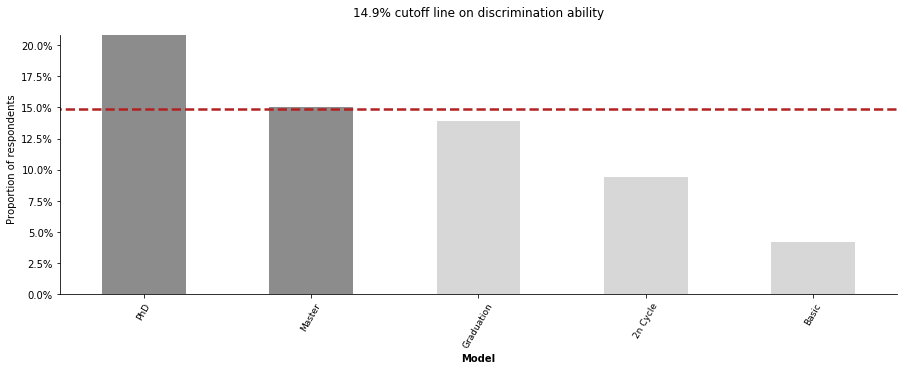

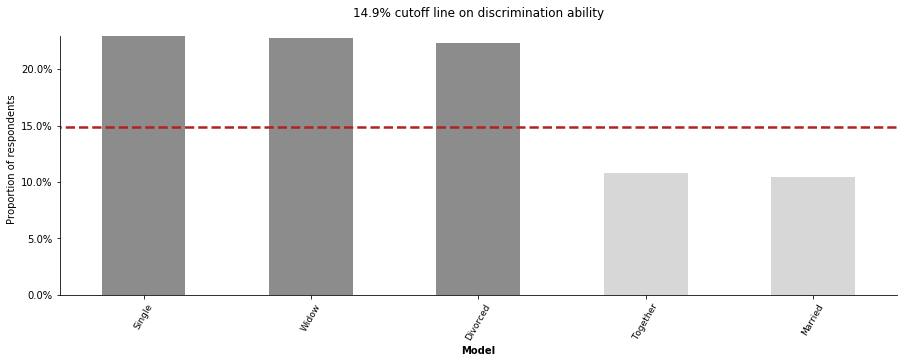

In [91]:
categorical_discrimination_plot(df, df.select_dtypes(include=["object", "category"]).columns, "Response")

In [92]:
cat_merged, clean_dict = categorical_merge(df, df.select_dtypes(include=["object", "category"]).columns, 'Response',merge_top = True)


{'Education': {'Graduation': 0, '2n Cycle': 0, 'Basic': 0, 'PhD': 1, 'Master': 1}, 'Marital_Status': {'Together': 0, 'Married': 0, 'Single': 1, 'Widow': 1, 'Divorced': 1}}


In [93]:
cat_merged.head(1)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,R_MntFishProducts,R_MntSweetProducts,R_MntGoldProds,RFM,R_NumWebPurchases,R_NumCatalogPurchases,R_NumStorePurchases,R_Mnt_NumWebPurchases,R_Mnt_NumCatalogPurchases,R_Mnt_NumStorePurchases
ID,,,,,,,,,,,,,,,,,,,,,
67,1,1,46423,1,1,6,68,0,16,0,...,0.0,0.0,0.086957,122,0.333333,0.0,0.666667,0.021739,0.0,0.043478


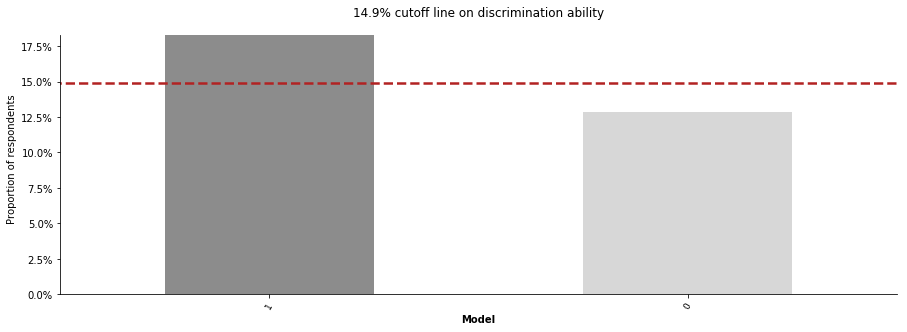

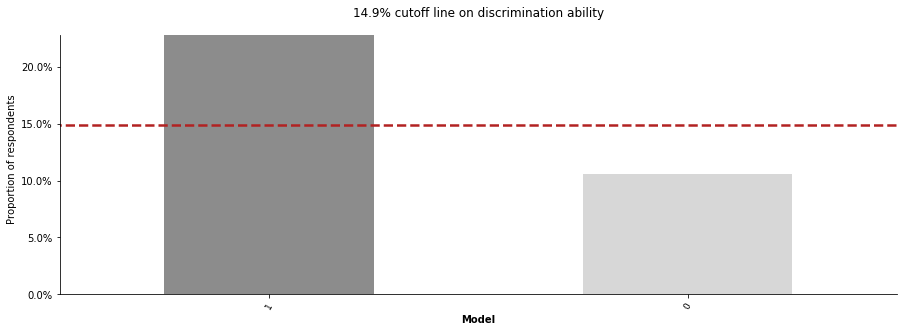

In [94]:
categorical_discrimination_plot(cat_merged, df.select_dtypes(include=["object", "category"]).columns, "Response")

In [95]:
# Test replace categories with binary variables
# train
df.replace(clean_dict, inplace=True)

In [96]:
# Deal with strange categories

clean_dict_test = clean_dict.copy()

for feature in clean_dict_test:
    
    for category in df_test[feature].unique():
        if category not in clean_dict_test[feature].keys():
            clean_dict_test[feature].update({category: 0})
        


In [97]:
# test

df_test.replace(clean_dict_test, inplace=True)

df_test.head(1)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,R_MntFishProducts,R_MntSweetProducts,R_MntGoldProds,RFM,R_NumWebPurchases,R_NumCatalogPurchases,R_NumStorePurchases,R_Mnt_NumWebPurchases,R_Mnt_NumCatalogPurchases,R_Mnt_NumStorePurchases
ID,,,,,,,,,,,,,,,,,,,,,
2895,0,1,49980.0,0,1,79,104,1,54,13,...,0.066667,0.046154,0.071795,422,0.333333,0.111111,0.555556,0.015385,0.005128,0.025641


In [98]:
np.sort(df.columns)

array(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedTot', 'Age', 'Childnum', 'Complain',
       'Days_as_cust', 'Education', 'Frq', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines', 'Mnt_tot',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'RFM', 'R_DealFrq',
       'R_MntFishProducts', 'R_MntFrq', 'R_MntFruits', 'R_MntGoldProds',
       'R_MntIncome', 'R_MntMeatProducts', 'R_MntSweetProducts',
       'R_MntWines', 'R_Mnt_NumCatalogPurchases',
       'R_Mnt_NumStorePurchases', 'R_Mnt_NumWebPurchases',
       'R_NumCatalogPurchases', 'R_NumStorePurchases',
       'R_NumWebPurchases', 'Recency', 'Response', 'Teenhome'],
      dtype=object)

# Variable Worth
---

* Chi2
* LinReg
* Random Forest
* RFE (Logistic Reg)
* Extra tree classifier
* Decision Trees
* VI
* Eli5 Permutations

In [99]:
# Encode Categorical
#df = encode_categorical(cat_merged, cat_merged.select_dtypes(include=["object", "category"]).columns)

In [100]:
# Split data into features and Labels
x = df[df.columns.difference(['Response'])]
y = df['Response']

# Normalize Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_ = scaler.fit_transform(x)
x = pd.DataFrame(x_, columns = x.columns, index=x.index)

#### plot importance

In [101]:
# 4 rows 2 cols side by side

In [102]:
def plot_importance(df,measure, top = 20):
    to_plot = pd.DataFrame(df[measure]).head(top).sort_values(by=measure)

    # 1 font
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    # 2 axis style

    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'

    # plot
    my_range=range(1,len(to_plot.index)+1)
    fig, ax = plt.subplots(figsize=(5,6))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.hlines(y=my_range, xmin=0, xmax = to_plot[measure], color='grey', alpha=0.4)
    plt.plot(to_plot[measure], my_range, "o", markersize=6, color='#007acc', alpha=0.6)
    plt.yticks(my_range, to_plot.index,fontsize=10)
    # set labels style
    ax.set_title(measure, fontweight = 'bold')
    ax.set_xlabel('Importance', fontsize=10, fontweight='black', color = '#333F4B')
    ax.set_ylabel('')
    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)


### Chi2

In [103]:
continuous_flist = list(df.select_dtypes(include=["number"]).drop(["Response"], axis=1).columns)
categorical_flist = list(df.select_dtypes(include=["object"]).columns)

In [104]:
target = "Response"
chisq_rank=chisq_ranker(df, continuous_flist, categorical_flist, target)
chisq_rank
df_chisq_rank = pd.DataFrame(chisq_rank, index=["Chi-Squared", "p-value"]).transpose()
df_chisq_rank.sort_values("Chi-Squared", ascending=False, inplace=True)
df_chisq_rank["valid"]=df_chisq_rank["p-value"]<=0.05
# chi 
chi_sq = pd.DataFrame(df_chisq_rank['Chi-Squared']).rank(ascending=False).astype('int64')
chi_sq.head()

,Chi-Squared
AcceptedTot,1
AcceptedCmp5,2
R_MntFrq,3
Mnt_tot,4
R_NumStorePurchases,5


### Linear Regression

In [105]:
r_squared = []
coef = []
p_val = []

for var in x.columns: 
    x_ = x[var]
    mod = sm.OLS(y, sm.add_constant(x_)).fit()
    r_squared.append(np.round(mod.rsquared, decimals = 3))
    coef.append(np.round(mod.params[1], decimals = 3))
    p_val.append(mod.pvalues[1])

In [106]:
# DataFrame
LinReg = pd.DataFrame({"variable":x.columns, "R2": r_squared, "coef": coef, 'pvalue':p_val})
LinReg['valid']  = LinReg['pvalue'] <=0.05
LinReg.sort_values(by="R2", ascending = False,inplace=True)
LinReg.set_index("variable", inplace=True)
'''
print(LinReg)
clrs = ['gray' if x else 'lightgray' for x in LR['valid'] ]
plt.subplots(figsize=(7,12))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.barplot(y = LR.index, x = 'R2', data = LinReg,
            orient = "h", palette=clrs, edgecolor = "black")
plt.title("Dependent Variable: "+target, loc='left',fontweight = "bold")
plt.xlabel('R Squared')
plt.ylabel('Dependent Variables')
plt.show()
'''
LinReg_ = pd.DataFrame(LinReg.R2)
LinReg = pd.DataFrame(LinReg.R2).rank(ascending=False).astype('int64')
LinReg.rename(index=str, columns={"R2": "LinReg"},inplace=True)
LinReg.head()

,LinReg
variable,
AcceptedTot,1
AcceptedCmp5,2
AcceptedCmp1,3
R_NumStorePurchases,4
MntMeatProducts,5


### Random Forest

In [107]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(random_state=seed)
clf.fit(x,y)
preds = clf.predict(x)
rf_ = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=x.columns)
rf = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=x.columns).rank(ascending=False).astype('int64')
rf.sort_values(by='RF').head()

,RF
AcceptedTot,1
Days_as_cust,2
R_Mnt_NumStorePurchases,3
Income,4
RFM,5


### RFE 

In [108]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=seed)
rfe = RFE(model, 1)
fit = rfe.fit(x, y)
rfe = pd.DataFrame(rfe.ranking_, columns = ["RFE"], index=x.columns)
rfe_ = rfe.copy().sort_values(by='RFE',ascending=False)
rfe.sort_values(by='RFE').head()

,RFE
R_NumStorePurchases,1
AcceptedTot,2
Days_as_cust,3
RFM,4
R_MntMeatProducts,5


### Extra trees classifier

In [109]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(random_state = seed)
model.fit(x, y)
extc_ = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=x.columns)
extc = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=x.columns).rank(ascending=False).astype('int64')
extc.sort_values(by='Extratrees').head()

,Extratrees
AcceptedTot,1
RFM,2
Days_as_cust,3
AcceptedCmp1,4
AcceptedCmp5,5


### Decision Trees

In [110]:
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="entropy",random_state=seed)
dtree = dtree.fit(x, y)
dtree_ = pd.DataFrame(dtree.feature_importances_, columns = ["Dt"], index=x.columns)
dtree = pd.DataFrame(dtree.feature_importances_, columns = ["Dt"], index=x.columns).rank(ascending=False).astype('int64')
dtree.sort_values(by='Dt').head()

,Dt
AcceptedTot,1
Days_as_cust,2
Recency,3
RFM,4
R_MntMeatProducts,5


## WOE AND IV

In [111]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [112]:
final_iv, IV = data_vars(df[df.columns.difference(['Response'])],df.Response)
IV.set_index('VAR_NAME',inplace=True)
IV_rank = IV.rank(ascending=False).astype('int64')

In [113]:
transform_vars_list = df.columns.difference(['Response'])
transform_prefix = 'WOE_' 

df_woe = df.copy()

for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df_woe[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df_woe[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

In [114]:
woe_columns = [x for x in df_woe.columns if x.startswith('WOE_')]

In [115]:
df_woe = df_woe[woe_columns]
df_woe = pd.concat([df_woe, df.Response],axis=1)
df_woe.head(2)

,WOE_AcceptedCmp1,WOE_AcceptedCmp2,WOE_AcceptedCmp3,WOE_AcceptedCmp4,WOE_AcceptedCmp5,WOE_AcceptedTot,WOE_Age,WOE_Childnum,WOE_Complain,WOE_Days_as_cust,...,WOE_R_MntWines,WOE_R_Mnt_NumCatalogPurchases,WOE_R_Mnt_NumStorePurchases,WOE_R_Mnt_NumWebPurchases,WOE_R_NumCatalogPurchases,WOE_R_NumStorePurchases,WOE_R_NumWebPurchases,WOE_Recency,WOE_Teenhome,Response
ID,,,,,,,,,,,,,,,,,,,,,
67,-0.242439,-0.068242,-0.205974,-0.172861,-0.306854,-0.298514,-0.015082,-0.367438,0.00566,-0.554797,...,-0.046292,-0.705227,-1.194377,-0.293236,-1.097764,-1.207494,-0.058463,0.895478,-0.016888,0
3828,-0.242439,-0.068242,-0.205974,-0.172861,-0.306854,-0.298514,0.045369,0.084984,0.00566,0.138909,...,0.044835,0.233421,0.782468,0.650298,0.662987,0.025566,-0.058463,-0.258705,-0.016888,0


### Eli 5 Permutations

In [116]:
import eli5
from eli5.sklearn import PermutationImportance
clf = RandomForestClassifier(random_state=seed).fit(x, y)
perm = PermutationImportance(clf, random_state=seed).fit(x, y)

In [117]:
eli5.show_weights(perm, feature_names = x.columns.tolist(), top=10)

Weight,Feature
0.0251 ± 0.0024,AcceptedTot
0.0242 ± 0.0016,Days_as_cust
0.0219 ± 0.0044,Recency
0.0201 ± 0.0037,RFM
0.0156 ± 0.0034,R_NumStorePurchases
0.0156 ± 0.0013,R_DealFrq
0.0114 ± 0.0009,Marital_Status
0.0111 ± 0.0026,R_Mnt_NumStorePurchases
0.0092 ± 0.0048,Income
0.0081 ± 0.0024,R_MntFrq


In [118]:
perm_df_ = pd.DataFrame(perm.feature_importances_, columns = ["Perm"], index=x.columns)
perm_df = pd.DataFrame(perm.feature_importances_, columns = ["Perm"], index=x.columns).rank(ascending=False).astype('int64')
perm_df.sort_values(by='Perm').head()

,Perm
AcceptedTot,1
Days_as_cust,2
Recency,3
RFM,4
R_NumStorePurchases,5


In [119]:
import xgboost
import shap

In [120]:
# train XGBoost model
shap.initjs()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(x, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

### plot feature importance of models

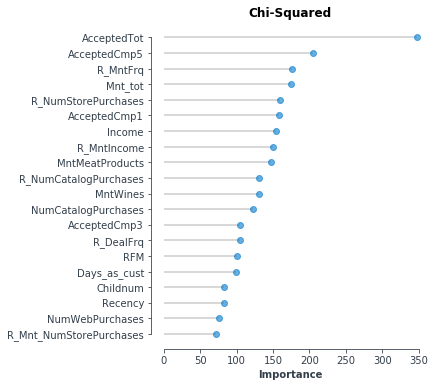

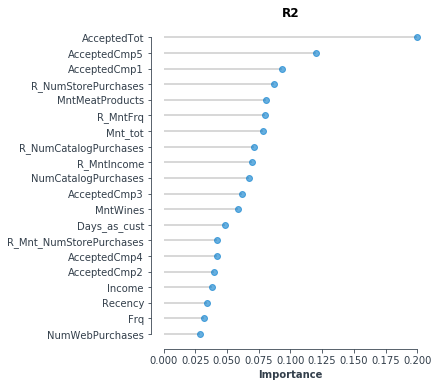

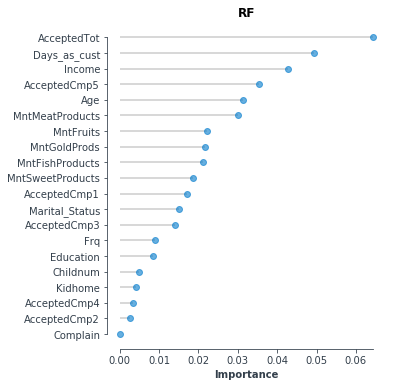

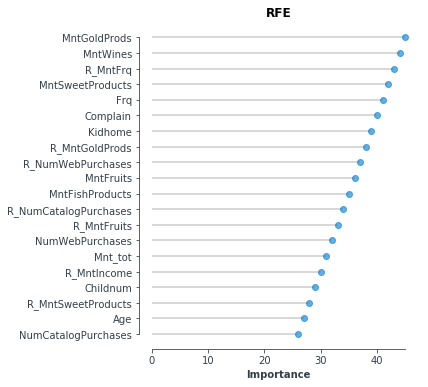

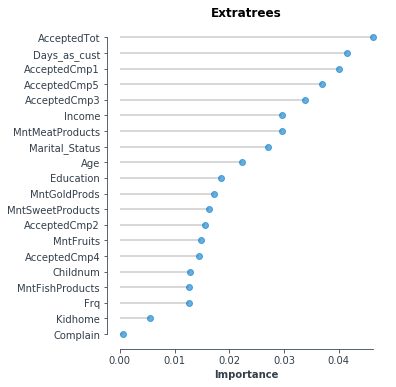

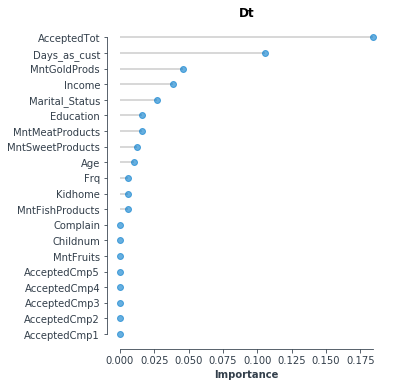

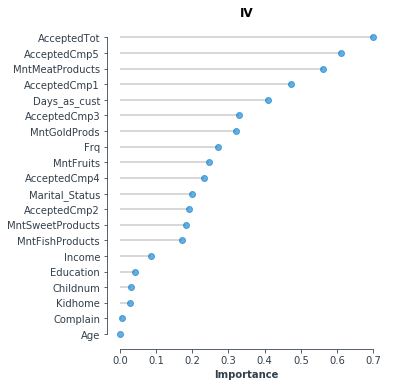

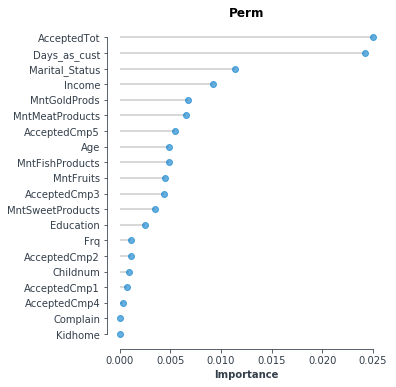

In [121]:
methds = [df_chisq_rank,LinReg_,rf_,rfe_,extc_,dtree_,IV,perm_df_]
for met in methds:
    plot_importance(met,met.columns[0])

# Compare All Models

In [122]:
from functools import reduce
dfs = [chi_sq, LinReg, rf, rfe, extc, dtree, IV_rank, perm_df]
compare_models = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)

# Vote
compare_models['Ranking'] = compare_models.sum(axis=1).rank(ascending=True).astype('int64')
compare_models.sort_values(by='Ranking',inplace=True)
compare_models['Valid'] = df_chisq_rank.valid
compare_models

,Chi-Squared,LinReg,RF,RFE,Extratrees,Dt,IV,Perm,Ranking,Valid
AcceptedTot,1,1,1,2,1,1,2,1,1,True
R_NumStorePurchases,5,4,13,1,10,12,1,5,2,True
Days_as_cust,16,13,2,3,3,2,10,2,2,True
R_Mnt_NumStorePurchases,20,14,3,8,15,6,5,8,4,True
Recency,18,18,6,9,6,3,16,3,4,True
RFM,15,22,5,4,2,4,27,4,6,True
AcceptedCmp5,2,2,8,12,5,41,3,18,7,True
MntMeatProducts,9,5,12,18,9,18,6,14,7,True
Income,7,17,4,23,8,8,30,9,9,True
Mnt_tot,4,7,19,31,11,24,4,16,10,True


## VIF

In [123]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [124]:
features_ = df[list(compare_models[compare_models['Ranking'] <=15].index)]

In [125]:
vif = calculate_vif(features_)
vif

,Features,VIF
0,AcceptedTot,4.312620
1,R_NumStorePurchases,25.025725
2,Days_as_cust,4.625467
3,R_Mnt_NumStorePurchases,5.364882
4,Recency,86.600728
5,RFM,145.577934
6,AcceptedCmp5,2.689065
7,MntMeatProducts,14.387561
8,Income,25.686136
9,Mnt_tot,34.416204


In [126]:
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features_.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features_)

In [127]:
vif

,Features,VIF
0,AcceptedTot,4.284276
1,Days_as_cust,4.077000
2,R_Mnt_NumStorePurchases,2.743741
3,Recency,3.501894
4,AcceptedCmp5,2.651668
5,MntMeatProducts,8.733807
6,R_DealFrq,4.513024
7,R_MntMeatProducts,8.088744
8,R_NumCatalogPurchases,4.708534
9,R_MntFrq,9.771704


In [128]:
vif_selected_variables = list(vif['Features']) #+ ['Response']

In [129]:
vif_selected_variables

['AcceptedTot',
 'Days_as_cust',
 'R_Mnt_NumStorePurchases',
 'Recency',
 'AcceptedCmp5',
 'MntMeatProducts',
 'R_DealFrq',
 'R_MntMeatProducts',
 'R_NumCatalogPurchases',
 'R_MntFrq',
 'AcceptedCmp1']

# Remove correlated features by importance order

In [130]:
not_valid = compare_models.loc[compare_models.Valid==0].index.values
not_valid

array(['R_MntWines', 'Age', 'R_MntFishProducts', 'R_MntSweetProducts',
       'R_MntFruits', 'Complain'], dtype=object)

In [131]:
#### 1 Using correlation

# lista com variaveis ordenadas por importancia
# para cada ver a correlacao com as outras
# se for acima de 70% retirar essa var da lista

# Lista com features ordenadas por importância para explicar a variável target
col_ordered = compare_models.index

# Dataset com apenas as variáveis númericas
x_ = x[col_ordered]
columns = np.full(x_.columns.shape[0], True, dtype=bool)

corr = x_.corr()
to_keep = -1

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = x_.columns[columns][:to_keep]
# remove non valid variables
selected_columns = [x for x in selected_columns if x not in not_valid]
selected_columns
#df_after_remove = pd.concat([x[selected_columns].iloc[:,:to_keep],y],axis=1)    
#print(df_after_remove.columns)
#df_after_remove.head(1)

['AcceptedTot',
 'R_NumStorePurchases',
 'Days_as_cust',
 'Recency',
 'MntMeatProducts',
 'R_DealFrq',
 'R_MntMeatProducts',
 'R_NumCatalogPurchases',
 'AcceptedCmp1',
 'Marital_Status',
 'AcceptedCmp3',
 'MntGoldProds',
 'R_Mnt_NumCatalogPurchases',
 'R_MntGoldProds',
 'NumWebPurchases',
 'NumWebVisitsMonth',
 'MntFruits',
 'MntFishProducts',
 'MntSweetProducts',
 'AcceptedCmp2',
 'AcceptedCmp4',
 'NumStorePurchases',
 'R_NumWebPurchases',
 'Education',
 'NumDealsPurchases',
 'Childnum',
 'Kidhome']

# Decomposition 
---

* PCA 
* Factor Analysis
* FastICA
* TSNE
* LDA
* Kernel PCA
* Feature Agglomeration
* Gaussian Random Projection

## PCA

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [133]:
n_components = 20
i = 1
achieved = False
for n in range(n_components):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x)
    cumulative_var = np.sum(pca.explained_variance_ratio_ * 100)
    if cumulative_var >= 80 and achieved == False:
        threshold_80_percent = i
        achieved = True
        print('\n>>> PCA 80% of cumulative explained Variance achieved with: {} components\n'.format(i))
    i += 1
pca_board = pd.DataFrame({"Explained_Var": np.round(pca.explained_variance_ratio_ * 100, decimals=1),
                          "Cumulative_Var": np.round(np.cumsum(pca.explained_variance_ratio_ * 100),
                                                     decimals=2)})
pca_board.index.name = 'PC'
pca_board.index += 1
print(pca_board)


>>> PCA 80% of cumulative explained Variance achieved with: 10 components

    Explained_Var  Cumulative_Var
PC                               
1            26.8           26.77
2            11.8           38.55
3             9.8           48.39
4             8.0           56.43
5             6.5           62.97
6             5.1           68.02
7             4.2           72.26
8             3.3           75.61
9             3.0           78.57
10            2.4           80.96
11            2.1           83.02
12            1.9           84.94
13            1.7           86.66
14            1.6           88.26
15            1.5           89.79
16            1.3           91.07
17            1.2           92.25
18            1.0           93.22
19            0.9           94.11
20            0.9           94.99


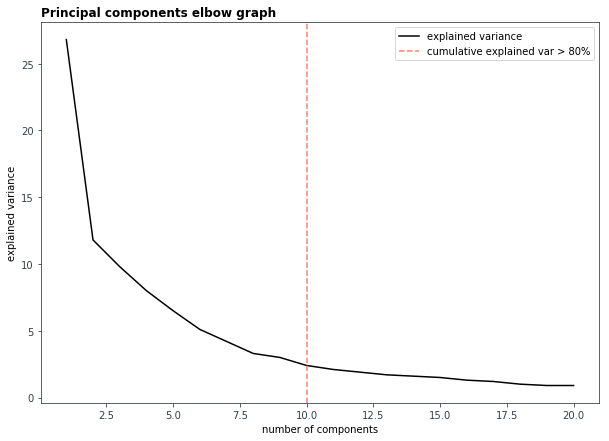

In [134]:
# plot elobe graph

plt.figure(figsize=(10, 7))
plt.plot(pca_board.Explained_Var, color="black", label="explained variance")
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title("Principal components elbow graph", loc="left", fontweight="bold")
plt.axvline(x=threshold_80_percent, alpha=2, color="salmon", linestyle="--",
            label="cumulative explained var > 80%")
plt.legend()
#plt.show()

    # See how each variable is epxlinaed by each component
pca_index = []

for i in range(1, n_components + 1):
    pca_index.append('PC' + str(i))

In [135]:
print(pd.DataFrame(np.round(pca.components_ * 100, 2),columns=x.columns,index=pca_index))

agg_pca = pd.DataFrame(principalComponents,columns=pca_index)
pca_df = pd.DataFrame(principalComponents, columns=pca_index, index=x.index).iloc[:, : threshold_80_percent]
pca_df = pd.concat([pca_df, df['Response']],axis=1)
#pca_df.to_excel("df_PCA.xlsx")

      AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
PC1          13.05          2.37          2.27          9.36         15.66   
PC2          -1.00          0.50         -0.58          7.87         -0.20   
PC3          -1.53         -0.05          0.77          0.03         -2.62   
PC4          -3.87         -0.04         -3.19          4.03         -3.12   
PC5          -9.37          0.34         -2.82          6.11        -12.10   
PC6          37.34         12.87         15.54         46.17         46.32   
PC7           5.01          2.01         37.13         -2.40          7.00   
PC8          -0.70         -2.10         58.16        -33.30         -6.96   
PC9          12.61         -3.89        -23.91        -15.80         17.11   
PC10         -3.65          3.04        -26.93         26.50          8.53   
PC11         -3.22         -1.24        -28.27         39.83        -13.97   
PC12         23.20          2.04         19.30         -5.69    

In [136]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Response
ID,,,,,,,,,,,
67,-0.809906,0.792371,0.715204,-0.523118,0.231709,0.068501,-0.113152,0.018288,0.238226,0.019844,0
3828,1.028261,-0.432112,-0.434778,0.312748,0.470928,-0.505876,-0.038942,0.095833,0.056138,0.213251,0
3409,-0.285483,-0.368740,0.605481,0.327997,0.039011,0.314861,0.480147,0.558096,-0.171324,-0.785501,0
9451,1.028023,-0.318300,-0.444433,0.704355,0.514666,-0.391068,0.129448,-0.100894,0.160467,-0.151734,0
6211,-0.828008,0.525254,-0.275814,-0.166023,-0.663175,0.010228,-0.130732,0.037532,-0.025651,-0.067390,0


## Factor Analysis

In [137]:
from sklearn.decomposition import FactorAnalysis as FA

In [138]:
n_components = threshold_80_percent
fa = FA(n_components = n_components, random_state=seed)
fa_df = fa.fit_transform(x)
sum(fa.noise_variance_)  

0.9631416325658947

In [139]:
fa_index = []
for i in range(1, n_components + 1):
    fa_index.append('Fact' + str(i))
fa_df = pd.DataFrame(fa_df, columns = fa_index,index=x.index)
fa_df = pd.concat([fa_df, df['Response']],axis=1)
fa_df.head()

,Fact1,Fact2,Fact3,Fact4,Fact5,Fact6,Fact7,Fact8,Fact9,Fact10,Response
ID,,,,,,,,,,,
67,-1.251478,-0.140457,-0.152598,0.116644,-1.387838,-0.092602,-1.583889,0.168579,1.035578,0.221977,0
3828,0.423191,-0.464838,2.019676,-1.096858,0.551726,0.133886,0.867247,0.037749,-0.045855,0.219754,0
3409,-0.158051,2.228083,-0.033909,1.028487,0.626806,0.698284,0.814756,0.140286,-0.668858,-0.473987,0
9451,0.278522,0.977900,1.671330,-0.390954,1.533862,-1.728088,0.225450,0.500031,0.116961,0.566531,0
6211,-1.400568,-0.898799,-0.368700,0.184549,0.014160,-0.170857,-0.336057,-0.533657,-0.449540,0.250631,0


## ICA

In [140]:
from sklearn.decomposition import FastICA

In [141]:
n_components = threshold_80_percent
ica = FastICA(n_components=n_components, random_state=seed)
ica_df = ica.fit_transform(x)

In [142]:
ica_index = []
for i in range(1, n_components + 1):
    ica_index.append('ICA' + str(i))
ica_df = pd.DataFrame(ica_df, columns = ica_index,index=x.index)
ica_df = pd.concat([ica_df, df['Response']],axis=1)
ica_df.head()

,ICA1,ICA2,ICA3,ICA4,ICA5,ICA6,ICA7,ICA8,ICA9,ICA10,Response
ID,,,,,,,,,,,
67,0.011172,-0.000455,-0.005046,-0.009369,-0.035371,0.030746,0.008045,-0.033047,-0.025256,0.024706,0
3828,-0.042609,-0.021474,-0.016525,-0.009406,0.013360,-0.022553,-0.016197,0.019122,0.022735,0.018532,0
3409,-0.003301,0.053710,-0.014193,0.079819,0.019428,-0.017438,0.003478,-0.033738,-0.029366,-0.014856,0
9451,-0.047360,0.013831,-0.012333,-0.010028,0.035104,-0.019728,-0.028729,0.017514,-0.000218,0.012383,0
6211,0.028177,0.001681,-0.008779,-0.000628,-0.001344,0.030976,0.027076,0.017837,-0.007809,-0.019243,0


## TSNE

In [143]:
from sklearn.manifold import TSNE 


In [144]:
n_components = 3
tsne = TSNE(n_components=n_components, n_iter=250,random_state=seed)
tsne_df = tsne.fit_transform(x.values)

In [145]:
tsne_names = []
for i in range(1, n_components + 1):
    tsne_names.append('TSNE' + str(i))

tsne_df = pd.DataFrame(tsne_df, index = x.index, columns=tsne_names)
tsne_df = pd.concat([tsne_df, df['Response']],axis=1)
tsne_df.head()

,TSNE1,TSNE2,TSNE3,Response
ID,,,,
67,-0.436040,1.164724,0.604223,0
3828,0.140193,-0.477769,-0.247487,0
3409,0.488393,0.969068,-0.412692,0
9451,0.132900,-0.465626,-0.237191,0
6211,-1.065690,0.056261,1.134965,0


# LDA

In [146]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#n_components = 10
#lda = LDA(n_components = n_components)
#lda_df = lda.fit_transform(x, y)

In [147]:
#lda_df.shape

# Kernel PCA

In [148]:
from sklearn.decomposition import KernelPCA as KPCA

In [149]:
n_components = threshold_80_percent
kpca = KPCA(n_components = n_components, random_state=seed, kernel='linear')
kpca_df = kpca.fit_transform(x)

In [150]:
kpca_names = []
for i in range(1, n_components + 1):
    kpca_names.append('KPCA' + str(i))

kpca_df = pd.DataFrame(kpca_df, index = x.index, columns=kpca_names)
kpca_df = pd.concat([kpca_df, df['Response']],axis=1)
kpca_df.head()

,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,KPCA6,KPCA7,KPCA8,KPCA9,KPCA10,Response
ID,,,,,,,,,,,
67,0.809906,0.792371,-0.715204,-0.523118,0.231709,-0.068501,0.113153,-0.018288,-0.238228,0.019846,0
3828,-1.028261,-0.432112,0.434778,0.312748,0.470928,0.505876,0.038941,-0.095832,-0.056138,0.213252,0
3409,0.285483,-0.368740,-0.605481,0.327997,0.039011,-0.314861,-0.480147,-0.558096,0.171325,-0.785502,0
9451,-1.028023,-0.318300,0.444433,0.704355,0.514666,0.391068,-0.129448,0.100892,-0.160468,-0.151732,0
6211,0.828008,0.525254,0.275814,-0.166023,-0.663175,-0.010228,0.130732,-0.037533,0.025650,-0.067389,0


# Feature Agglomeration

In [151]:
from sklearn import cluster

In [152]:
n_clusters = threshold_80_percent
agglo = cluster.FeatureAgglomeration(n_clusters=n_clusters)
agglo.fit(x) 
x_reduced = agglo.transform(x)

In [153]:
clust_names = []
for i in range(1, n_clusters + 1):
    clust_names.append('CLUST' + str(i))

In [154]:
x_reduced = pd.DataFrame(x_reduced, index = x.index, columns=clust_names)
x_reduced = pd.concat([x_reduced, df['Response']],axis=1)
x_reduced.head()

,CLUST1,CLUST2,CLUST3,CLUST4,CLUST5,CLUST6,CLUST7,CLUST8,CLUST9,CLUST10,Response
ID,,,,,,,,,,,
67,0.613805,0.051884,0.577381,0.022903,0.305575,1.0,0.042690,0.0000,0.265325,1.0,0
3828,0.543338,0.078206,0.233059,0.481257,0.311574,0.0,0.695468,0.0000,0.774936,0.0,0
3409,0.377944,0.158259,0.288690,0.116949,0.437184,1.0,0.706047,0.0625,0.401604,0.0,0
9451,0.577551,0.065383,0.250259,0.473040,0.353969,0.0,0.964646,0.0000,0.748069,0.0,0
6211,0.437445,0.057094,0.288690,0.013424,0.358409,0.0,0.462599,0.0000,0.184705,1.0,0


# Gaussian Random Projection

In [155]:
from sklearn.random_projection import GaussianRandomProjection

n_components = threshold_80_percent
grp = GaussianRandomProjection(n_components =n_components,random_state=seed)
rand_proj = grp.fit_transform(x)

In [156]:
rand_names = []
for i in range(1, n_components + 1):
    rand_names.append('GRP' + str(i))

grp_df = pd.DataFrame(rand_proj, index = x.index, columns=rand_names)
grp_df = pd.concat([grp_df, df['Response']],axis=1)
grp_df.head()

,GRP1,GRP2,GRP3,GRP4,GRP5,GRP6,GRP7,GRP8,GRP9,GRP10,Response
ID,,,,,,,,,,,
67,0.491865,0.168557,0.923474,0.339993,-0.498594,-0.449854,0.201955,-0.669956,-0.316022,0.799339,0
3828,0.661241,0.038519,1.085218,0.383266,0.444486,-1.337309,1.471578,-0.613053,-2.247389,-0.233343,0
3409,0.495962,0.014785,0.424602,-0.088210,-0.471883,-0.542405,1.155794,-0.588679,-0.806568,0.290853,0
9451,0.402433,-0.188029,1.266110,1.068602,0.304885,-1.367569,0.889981,-1.084449,-2.277606,0.023013,0
6211,0.231310,0.164170,1.101483,0.031763,-0.481775,-0.508159,0.233581,-1.003808,-0.210673,0.287452,0


# Comparing choice of features with RFECV

In [157]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()

selector = RFECV(estimator, step=1, cv = 5)
selector = selector.fit(x,y)

In [158]:
rfecv_df = pd.DataFrame({'var':x.columns,'rank':selector.ranking_,'support':selector.support_ }).sort_values(by='rank')
rfecv_features = rfecv_df.loc[rfecv_df.support == True]['var'].values
rfecv_features

array(['AcceptedCmp1', 'R_NumStorePurchases', 'R_Mnt_NumWebPurchases',
       'R_Mnt_NumStorePurchases', 'R_Mnt_NumCatalogPurchases',
       'R_MntWines', 'R_MntMeatProducts', 'R_MntFishProducts',
       'R_DealFrq', 'RFM', 'NumWebVisitsMonth', 'NumStorePurchases',
       'NumDealsPurchases', 'Recency', 'MntMeatProducts',
       'NumCatalogPurchases', 'Teenhome', 'AcceptedCmp2',
       'Marital_Status', 'AcceptedTot', 'AcceptedCmp3', 'Days_as_cust',
       'AcceptedCmp4', 'Income', 'AcceptedCmp5', 'Education'],
      dtype=object)

# Best power transformation for selected features

In [159]:
# 2) & 3) perform power transformations on scaled features and select the best
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import boxcox


# define a set of transformations
trans_dict = {'x': lambda x: x,
              #'1/x': lambda x: np.divide(1, x),
              'log': np.log,
              'sqrt': np.sqrt,
              'exp': np.exp,
              '**1/3': lambda x: np.power(x, 1/3),
              '**1/4': lambda x: np.power(x, 0.25),
              '**1/5': lambda x: np.power(x, 1/5),
              '**1/6': lambda x: np.power(x, 1/6),
              '**1/7': lambda x: np.power(x, 1/7),
              '**2': lambda x: np.power(x, 2),
              '**4': lambda x: np.power(x, 4)}

In [160]:
# 1 SCALING

scaler = MinMaxScaler()
X_01 = scaler.fit_transform(df.drop(columns = 'Response').values)

column_names01 = [s + "_01T" for s in df.drop(columns = 'Response').columns]
df_01T = pd.concat([df, pd.DataFrame(X_01, index=df.index, columns=column_names01)], axis=1)

display(df_01T.head(3))
print(df_01T.columns)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,R_MntFishProducts_01T,R_MntSweetProducts_01T,R_MntGoldProds_01T,RFM_01T,R_NumWebPurchases_01T,R_NumCatalogPurchases_01T,R_NumStorePurchases_01T,R_Mnt_NumWebPurchases_01T,R_Mnt_NumCatalogPurchases_01T,R_Mnt_NumStorePurchases_01T
ID,,,,,,,,,,,,,,,,,,,,,
67,1,1,46423,1,1,6,68,0,16,0,...,0.000000,0.000000,0.173913,0.024775,0.333333,0.000000,0.666667,0.173913,0.000000,0.144928
3828,0,0,71107,0,1,61,533,10,217,198,...,0.252507,0.218538,0.293896,0.774775,0.269231,0.356643,0.500000,0.042200,0.085908,0.032655
3409,0,1,36108,1,0,68,141,8,129,3,...,0.014976,0.054081,0.277286,0.725225,0.583333,0.128788,0.333333,0.165192,0.056047,0.039331


Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Days_as_cust', 'Mnt_tot', 'Frq',
       'Childnum', 'R_MntFrq', 'R_MntIncome', 'AcceptedTot', 'R_DealFrq',
       'R_MntWines', 'R_MntFruits', 'R_MntMeatProducts', 'R_MntFishProducts',
       'R_MntSweetProducts', 'R_MntGoldProds', 'RFM', 'R_NumWebPurchases',
       'R_NumCatalogPurchases', 'R_NumStorePurchases', 'R_Mnt_NumWebPurchases',
       'R_Mnt_NumCatalogPurchases', 'R_Mnt_NumStorePurchases', 'Education_01T',
       'Marital_Status_01T', 'Income_01T', 'Kidhome_01T', 'Teenhome_01T',
       'Recency_01T', 'MntWines_01T', 'MntFruits_01T', 'MntMeatPro

In [161]:
# 2 / 3 Chi square

target = "Response"

# best transformation dictionary for each feature
best_power_dict = {}

# take scaled columns

scaled_cols = [col for col in df_01T if col.endswith('01T')]

for feature in scaled_cols:
    max_test_value, max_trans, best_power_trans = 0, "", None
    for trans_key, trans_value in trans_dict.items():
        
        # apply transformation itself
        
        feature_trans = trans_value(df_01T[feature])
        if trans_key == "log":
            feature_trans.loc[np.isfinite(feature_trans) == False] = -50
            
        # bin feature
        
        bindisc = KBinsDiscretizer(n_bins = 10, encode = "ordinal", strategy = "uniform")
        feature_bin = bindisc.fit_transform(feature_trans.values[:, np.newaxis])
        feature_bin = pd.Series(feature_bin[:, 0], index = df_01T.index)
        
        # obtain contigency table
        
        df_ = pd.DataFrame(data = {feature: feature_bin, target: df_01T[target]})
        cont_tab = pd.crosstab(df_[feature], df_[target], margins = False)
        
        # compute Chi-Square test
        
        chi_test_value = stats.chi2_contingency(cont_tab)[0]
        if chi_test_value > max_test_value:
            max_test_value, max_trans, best_power_trans = chi_test_value, trans_key, feature_trans
            
    
    best_power_dict[feature] = (max_test_value, max_trans, best_power_trans)
    df_01T[feature] = best_power_trans

In [162]:
# BEST TRANSFORM
print("The best power transformations:")
for key in best_power_dict:
    print("\t>>>", key, best_power_dict[key][1]) 

df_01T.head(3, )

The best power transformations:
	>>> Education_01T x
	>>> Marital_Status_01T x
	>>> Income_01T **4
	>>> Kidhome_01T x
	>>> Teenhome_01T x
	>>> Recency_01T **1/4
	>>> MntWines_01T sqrt
	>>> MntFruits_01T x
	>>> MntMeatProducts_01T **1/3
	>>> MntFishProducts_01T x
	>>> MntSweetProducts_01T **1/4
	>>> MntGoldProds_01T **1/3
	>>> NumDealsPurchases_01T sqrt
	>>> NumWebPurchases_01T x
	>>> NumCatalogPurchases_01T exp
	>>> NumStorePurchases_01T exp
	>>> NumWebVisitsMonth_01T sqrt
	>>> AcceptedCmp3_01T x
	>>> AcceptedCmp4_01T x
	>>> AcceptedCmp5_01T x
	>>> AcceptedCmp1_01T x
	>>> AcceptedCmp2_01T x
	>>> Complain_01T x
	>>> Age_01T sqrt
	>>> Days_as_cust_01T **2
	>>> Mnt_tot_01T **1/4
	>>> Frq_01T **2
	>>> Childnum_01T x
	>>> R_MntFrq_01T x
	>>> R_MntIncome_01T **2
	>>> AcceptedTot_01T x
	>>> R_DealFrq_01T sqrt
	>>> R_MntWines_01T **2
	>>> R_MntFruits_01T **1/6
	>>> R_MntMeatProducts_01T sqrt
	>>> R_MntFishProducts_01T **1/6
	>>> R_MntSweetProducts_01T **1/3
	>>> R_MntGoldProds_01T sqrt
	>>> RF

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,R_MntFishProducts_01T,R_MntSweetProducts_01T,R_MntGoldProds_01T,RFM_01T,R_NumWebPurchases_01T,R_NumCatalogPurchases_01T,R_NumStorePurchases_01T,R_Mnt_NumWebPurchases_01T,R_Mnt_NumCatalogPurchases_01T,R_Mnt_NumStorePurchases_01T
ID,,,,,,,,,,,,,,,,,,,,,
67,1,1,46423,1,1,6,68,0,16,0,...,0.000000,0.000000,0.417029,0.157400,0.333333,0.000000,0.816497,0.704801,0.000000,0.724756
3828,0,0,71107,0,1,61,533,10,217,198,...,0.795022,0.602341,0.542122,0.880213,0.269231,0.597196,0.707107,0.530962,0.441243,0.565360
3409,0,1,36108,1,0,68,141,8,129,3,...,0.496478,0.378164,0.526580,0.851602,0.583333,0.358870,0.577350,0.697586,0.382694,0.583163


In [163]:
# list of different feature selection methods
feat_select_dict = {'vif':[col + '_01T' for col in vif_selected_variables],
                    'correlation':[col + '_01T' for col in selected_columns],
                    'rfecv': [col + '_01T' for col in list(rfecv_features)]}

In [164]:
# see best variable selection
from sklearn.model_selection import StratifiedKFold

n_splits = 10
selectors_df = pd.DataFrame(index=range(len(feat_select_dict.keys())*n_splits), columns=(['method','recall', 'accuracy', 'precision', 'f1']))
CV = StratifiedKFold(n_splits=n_splits, random_state=seed)
scoring = ['accuracy','precision','recall','f1'] 


In [165]:
entries = []
comparing_selectors =pd.DataFrame()

for score in scoring:
   
    entries = []
    
    for selector in feat_select_dict.keys():

        x_train = scaler.fit_transform(df_01T[feat_select_dict[selector]])
        y_train = df_01T['Response']

        accuracies = cross_val_score(LogisticRegression(n_jobs=-1),x_train, y_train, scoring= score, cv=CV)

        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((selector, fold_idx, model.__class__.__name__, accuracy))
    
    _ = pd.DataFrame(entries, columns=['method', 'fold_idx','model', score])
    comparing_selectors[score] = _.groupby(['method'])[score].agg('mean')



In [166]:
comparing_selectors.sort_values(by=['f1', 'recall'], ascending=False, inplace=True)
comparing_selectors

,accuracy,precision,recall,f1
method,,,,
rfecv,0.909340,0.810323,0.511692,0.625383
correlation,0.903577,0.794372,0.484615,0.595083
vif,0.884528,0.728671,0.356769,0.478193


In [167]:
best_selector = comparing_selectors.index[0]

In [168]:
df_01T_best_selector = df_01T[feat_select_dict[best_selector]]
df_01T_best_selector = pd.concat([df_01T_best_selector,df_01T.Response], axis = 1)

### Transform Test Data

In [169]:
#df_test.loc[df_test['Marital_Status']==0 | df_test['Marital_Status']==1]


In [170]:
# Erros de coerência
df_test.replace( [np.inf, -np.inf], np.nan,inplace=True)
df_test.fillna(df_train.mean(), inplace=True)

In [171]:
df_test.shape

(448, 46)

In [172]:
scaler = MinMaxScaler()
scaler.fit(df.drop(columns = 'Response').values)
X_01 = scaler.transform(df_test.drop(columns = 'Response').values)
df_test_01T = pd.concat([ pd.DataFrame(X_01, index=df_test.index, columns=column_names01), df_test.Response], axis=1)


In [173]:
# Apply transformations to test data
for key in best_power_dict:
    df_test_01T[key] = trans_dict[best_power_dict[key][1]](df_test_01T[key])

In [174]:
df_test_01T = df_test_01T[df_01T_best_selector.columns]

In [175]:
df_test_01T.head(1)

,AcceptedCmp1_01T,R_NumStorePurchases_01T,R_Mnt_NumWebPurchases_01T,R_Mnt_NumStorePurchases_01T,R_Mnt_NumCatalogPurchases_01T,R_MntWines_01T,R_MntMeatProducts_01T,R_MntFishProducts_01T,R_DealFrq_01T,RFM_01T,...,AcceptedCmp2_01T,Marital_Status_01T,AcceptedTot_01T,AcceptedCmp3_01T,Days_as_cust_01T,AcceptedCmp4_01T,Income_01T,AcceptedCmp5_01T,Education_01T,Response
ID,,,,,,,,,,,,,,,,,,,,,
2895,0.0,0.745356,0.657711,0.663696,0.460157,0.306529,0.608015,0.695128,0.534522,0.836929,...,0.0,1.0,0.0,0.0,0.127624,0.0,0.039571,0.0,0.0,0


# Select best engineering for Models
---

* With best of variable selection
* Decomposition
* WOE

In [176]:
scaler = MinMaxScaler()
var_selection = pd.DataFrame(scaler.fit_transform(df_test_01T.drop(columns = 'Response').values), columns = df_test_01T.drop(columns = 'Response').columns, index = df_test_01T.index)
var_selection = pd.concat([var_selection, df_test_01T.Response], axis=1)
#df_test_01T

In [177]:
# let's choose engeneering that better predicts our target
df_collection = {'variable_selection': var_selection,#df_test_01T,
                 'woe': df_woe,
                 'pca': pca_df,
                 'fa': fa_df,
                 'ica':ica_df,
                 'tsne':tsne_df,
                 'kpca':kpca_df,
                 'feat_agglom':x_reduced,
                 'grp':grp_df}

In [178]:
n_splits = 5
selectors_df = pd.DataFrame(index=range(len(df_collection.keys())*n_splits), columns=(['method','recall', 'accuracy', 'precision', 'f1']))
CV = StratifiedKFold(n_splits=n_splits, random_state=seed)
scoring = ['accuracy','precision','recall','f1'] 



In [179]:
entries = []
comparing_eng = pd.DataFrame()

for score in scoring:
   
    entries = []
    
    for df_ in df_collection.keys():

        x_train = df_collection[df_].drop(columns = 'Response')
        y_train = df_collection[df_].Response

        accuracies = cross_val_score(LogisticRegression(n_jobs=-1),x_train, y_train, scoring= score, cv=CV)

        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((df_, fold_idx, df_, accuracy))
    
    _ = pd.DataFrame(entries, columns=['method', 'fold_idx','model', score])
    comparing_eng[score] = _.groupby(['method'])[score].agg('mean')


In [180]:
kpca

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=10, n_jobs=None,
     random_state=0, remove_zero_eig=False, tol=0)

In [181]:
comparing_eng.sort_values(by = 'f1', ascending=False)

,accuracy,precision,recall,f1
method,,,,
woe,0.903574,0.755609,0.523529,0.615724
kpca,0.901854,0.767508,0.484766,0.592367
pca,0.901854,0.767508,0.484766,0.592367
fa,0.889159,0.734206,0.391629,0.507759
variable_selection,0.870581,0.610159,0.346154,0.437343
feat_agglom,0.882790,0.793316,0.286652,0.420222
grp,0.866642,0.665128,0.216968,0.325690
ica,0.851041,0.000000,0.000000,0.000000
tsne,0.851041,0.000000,0.000000,0.000000


In [182]:
'''
# If test is decomposed

#n_components = threshold_80_percent
#kpca = KPCA(n_components = n_components, random_state=seed, kernel='linear')

scaler = MinMaxScaler()
scaler.fit(df.drop(columns = 'Response').values)
X_01 = scaler.transform(df_test.drop(columns = 'Response').values)
df_test_01T = pd.concat([ pd.DataFrame(X_01, index=df_test.index, columns=column_names01), df_test.Response], axis=1)

'''

"\n# If test is decomposed\n\n#n_components = threshold_80_percent\n#kpca = KPCA(n_components = n_components, random_state=seed, kernel='linear')\n\nscaler = MinMaxScaler()\nscaler.fit(df.drop(columns = 'Response').values)\nX_01 = scaler.transform(df_test.drop(columns = 'Response').values)\ndf_test_01T = pd.concat([ pd.DataFrame(X_01, index=df_test.index, columns=column_names01), df_test.Response], axis=1)\n\n"

In [183]:
'''
kpca_test_df = kpca.transform(df_test_01T.drop(columns='Response'))

kpca_test_df = pd.DataFrame(kpca_test_df, index = df_test_01T.index, columns=kpca_names)
kpca_test_df = pd.concat([kpca_df, df_test_01T['Response']],axis=1)
kpca_test_df.head()
'''

"\nkpca_test_df = kpca.transform(df_test_01T.drop(columns='Response'))\n\nkpca_test_df = pd.DataFrame(kpca_test_df, index = df_test_01T.index, columns=kpca_names)\nkpca_test_df = pd.concat([kpca_df, df_test_01T['Response']],axis=1)\nkpca_test_df.head()\n"

# Output

In [184]:
df_01T = df_01T[df_01T_best_selector.columns]

In [185]:
# Extract step 02 to excel
df_01T.to_excel("df_02.xlsx")
df_test_01T.to_excel('df_test_02.xlsx')